## LIBRERIA

In [1]:
## LIBRARIES -> Mac and Windows Version
import yaml
import time
import torch.nn as nn
import torch.autograd as autograd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
from torch.autograd.functional import hessian, jacobian
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from neuralsens import partial_derivatives as ns
from neuralsens.partial_derivatives import calculate_second_partial_derivatives_mlp,calculate_first_partial_derivatives_mlp
import torch.nn as nn
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.spatial  import Voronoi
import pandas as pd
import seaborn as sns
## Add Utilis related with Monotonic Training
import sys
## Windows Version
if sys.platform == 'win32':
    sys.path.insert(0, 'C:/Users/apolo/OneDrive - Universidad Pontificia Comillas/Escritorio/PhD/Codigo/NNMonotonic/Scripts/')
    sys.path.insert(0, 'C:/Users/apolo/OneDrive - Universidad Pontificia Comillas/Escritorio/IIT/NN Monotonic/Scripts/')
## Mac Version
if sys.platform == 'darwin':
    sys.path.insert(0,'/Users/alejandropolo/Library/CloudStorage/OneDrive-UniversidadPontificiaComillas/Escritorio/PhD/Codigo/LipschitzNN/Scripts/')
    sys.path.insert(0,'/Users/alejandropolo/Library/CloudStorage/OneDrive-UniversidadPontificiaComillas/Escritorio/PhD/Codigo/LipschitzNN/')
    sys.path.insert(0,'/Users/alejandropolo/Library/CloudStorage/OneDrive-UniversidadPontificiaComillas/Escritorio/IIT/NN Monotonic/Scripts/')

import Scripts
import MLP_Monotonic
import DNN
import train
import data_load_lipschitz
import Utils
import random

import Utilities as Utilities
import utilities_voronoi
import utilities_lipschitz
import importlib

from utilities_voronoi import *
importlib.reload(utilities_voronoi)
importlib.reload(MLP_Monotonic)
importlib.reload(Utilities)
importlib.reload(DNN)
importlib.reload(train)
importlib.reload(data_load_lipschitz)
importlib.reload(Utils)

from MLP_Monotonic import MLP_Monotonic
from data_load_lipschitz import data_load_lipschitz
from train import train
from DNN import DNN


## LIPSCHITZ EN NN

**REFERENCIAS**
1) https://arxiv.org/pdf/1805.10965.pdf 

(Básicamente lo que dice esta referencia es que puedo poner un upper bound a la constante de Lipschitz por la norma de los gradientes)

#### CALCULO DEL HESSIANO

In [ ]:

# defining a function
def func(x, y):
    return (2*x*y.pow(2) + x.pow(3) - 10).sum()
  
# defining the inputs
input_x = torch.tensor([2.])
input_y = torch.tensor([-3.])
inputs = (input_x, input_y)
print("inputs:\n", inputs)
  
# compute the hessian
output = hessian(func, inputs)
  
# printing the above computed hessian
print("Hessian:\n", output)



**EXPLICACION TEÓRICA**

La matriz del Hessiano se denota como $H$ y generalmente tiene la forma:

$$
H =
\begin{bmatrix}
    \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
    \frac{\partial^2 f}{\partial x_2 \partial x_1} & \frac{\partial^2 f}{\partial x_2^2} & \cdots & \frac{\partial^2 f}{\partial x_2 \partial x_n} \\
    \vdots & \vdots & \ddots & \vdots \\
    \frac{\partial^2 f}{\partial x_n \partial x_1} & \frac{\partial^2 f}{\partial x_n \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{bmatrix}
$$

Luego en este caso se tendría que:

$$
H =
\begin{bmatrix}
    6x & 4y \\
    4y & 4x
\end{bmatrix}
$$

In [ ]:
################## HESSIANO DE UNA FUNCION SIGMOIDAL ############################
  
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


# defining the inputs
input_x = torch.tensor([1.0])
print("inputs:\n", input_x)
  
# compute the hessian
output = hessian(sigmoid, input_x)
  
# printing the above computed hessian
print("Hessian:\n", output)

In [ ]:
# Create a simple neural network model
from torch.autograd.functional import hessian, jacobian

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        self.fc2 = nn.Linear(1, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
torch.manual_seed(0)
# Define an input point for which to calculate the local Lipschitz constant
x_input = torch.tensor([1.0], requires_grad=True)

# Instantiate the model
model = SimpleNet()
# Print layer names and weights

for name, param in model.named_parameters():
    print(f"Layer: {name}")
    print(param)

# compute the hessian
hessian_matrix = batch_hessian(model, x_input)

print('Hessian',hessian_matrix)
# Calculate the local Lipschitz constant as the maximum norm of the gradient
local_lipschitz_constant = torch.norm(hessian_matrix, p=float('inf'))

print("Global Lipschitz Constant:", local_lipschitz_constant.item())


In [ ]:
######## CUADRAN LOS RESULTADOS
c = -0.0075+0.5364
input = torch.tensor([c], requires_grad=True)
((-0.0075)**2)*(-0.8230)*hessian(sigmoid, input)


In [ ]:
############################################## EJEMPLO -> CALCULO DE LA CONSTANTE DE LIPSCHITZ PARA UNA RED NEURONAL (NO PARA LA DERIVADA) ##############################################
# Create a simple neural network model
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
torch.manual_seed(0)
# Define an input point for which to calculate the local Lipschitz constant
x_input = torch.tensor([1.0, 2.0], requires_grad=True)

# Instantiate the model
model = SimpleNet()

# Calculate the gradient of the model's output with respect to the input
output = model(x_input)
gradient = autograd.grad(outputs=output, inputs=x_input, grad_outputs=torch.ones_like(output), create_graph=True)[0]

# Calculate the local Lipschitz constant as the maximum norm of the gradient
local_lipschitz_constant = torch.norm(gradient, p=float('inf'))

print("Local Lipschitz Constant:", local_lipschitz_constant.item())


### 1-DIMENSION

#### DATA GENERATION

In [ ]:
## Reproducibilidad
torch.manual_seed(0)

# Definir la función cuadrática
def quadratic_function(x):
    return x ** 2

# Generar datos de entrenamiento en el intervalo [-1, 5]
X = torch.linspace(-0.5, 1.5, 1000,dtype=torch.float).reshape(-1,1)
y = quadratic_function(X)

plt.scatter(X.flatten(), y.flatten(),label='Datos de entrenamiento')
plt.legend()
plt.show()

In [ ]:
### SEPARAMOS LOS DATOS EN TRAIN Y TEST
## TRAIN TEST SPLIT
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X, y, test_size=0.25, random_state=2023)

## Convertimos los datos a un dataset para pytorch
n_samples = len(X_train_tensor)
train_dt = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
train_dataload = DataLoader(train_dt,batch_size=64) # create your dataloader

## Convertimos los datos a un dataset para pytorch
n_samples = len(X_test_tensor)
val_dt = TensorDataset(X_test_tensor,y_test_tensor) # create your datset
val_dataload = DataLoader(val_dt,batch_size=n_samples) # create your dataloader

#### MODELLING

In [ ]:
torch.manual_seed(0)

class ExponentialLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(ExponentialLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = nn.Parameter(torch.Tensor(out_features))

    def forward(self, input):
        return F.linear(input, torch.exp(self.weight), self.bias)

######################## CLASE CON PESOS EXPONENCIALES

class MLP_Exponential(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(MLP_Exponential, self).__init__()
        self.linear1 = ExponentialLinear(in_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.linear2 = ExponentialLinear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        return x
    
######################## CLASE SIN RESTRICCIONES

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(in_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        return x


In [ ]:
torch.manual_seed(0)

in_dim = 1 ## Dimension del input
out_dim = 1 ## Dimension del output
hidden_dim=2 ## Numero de neuronas

## Definir el modelo
model = MLP(in_dim=in_dim,hidden_dim=hidden_dim, out_dim=out_dim)
criterion = nn.MSELoss()
monotone_relations =[]

mlp_model = MLP_Monotonic(_model_name="Prueba",_model = model)
print('------------------ Entrenamiento NO MONOTONO (Sin Reestricciones) ------------------')

mlp_model.train_adjusted_std(train_data=train_dataload,val_data=val_dataload,criterion=criterion,
                                 n_epochs=500,categorical_columns=[],verbose=1,n_visualized=1,
                                 monotone_relations=monotone_relations,optimizer_type='Adam',
                                 learning_rate=0.01,delta=0.0,patience=50,
                                 delta_synthetic=0.0,delta_external=0.0,std_growth=0.0,epsilon_synthetic=0.0,
                                 model_path='./Models/checkpoint_mlp_',external_points=None,seed=2023)

print('------------------ Resultados Entrenamiento ------------------')
### Ploteado de resultados
mlp_model.plot_history()

x_test = torch.linspace(-0.5, 1.5, 100).reshape(-1,1)
y_pred = mlp_model.predict(x_test).detach().numpy()
plt.scatter(x_test,quadratic_function(x_test), label='Real data',color='blue')
plt.scatter(x_test,y_pred, label='Predicted data', color='orange')
plt.title('Predicción de la función cuadrática')
plt.legend()

In [ ]:
#### REPRESENTACIÓN -> DERIVADA DE LA FUNCIÓN CUADRÁTICA
x = torch.linspace(-0.5, 2.0, 100, dtype=torch.float).reshape(-1, 1)
x.requires_grad = True  # Habilitar el seguimiento de gradientes para x

# Calcular la salida del modelo
mlp_model_ = mlp_model._model
Y = mlp_model_(x)

# Calcular la derivada de Y con respecto a x
y = torch.sum(Y)
y.backward()



# plotear la función y la derivada
function_line, = plt.plot(x.detach().numpy(), Y.detach().numpy(), label='Function')
function_line.set_color("red")
derivative_line, = plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label='Derivative')
derivative_line.set_color("green")

plt.xlabel('x')
plt.legend()
plt.show()

In [ ]:
# Ejemplo de uso
np.random.seed(2023)
print('------------------ COMPROBACIÓN EN UN CONJUNTO DE PUNTOS ------------------')
x_input = torch.tensor([-0.3, 0.0, 0.5, 1.7], requires_grad=True).reshape(-1, 1)
mlp = mlp_model._model  # Reemplaza mlp_positive por tu modelo
hessian_matrix = Utilities.batch_hessian(mlp, x_input)
global_lipschitz_constant = torch.norm(hessian_matrix, p=float('inf'))

conjunto_intervalos, dict_intervalos,x_reentrenamiento = utilities_voronoi.calcular_intervalos(x_input, mlp, global_lipschitz_constant)

intervalo_deseado = [-0.5, 2.5]

if utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado):
    print("El conjunto de intervalos rellena completamente el intervalo deseado.")
else:
    print("El conjunto de intervalos NO rellena completamente el intervalo deseado.")
#utilities_voronoi.plot_intervalos(conjunto_intervalos, intervalo_deseado)
utilities_voronoi.plot_intervalos(dict_intervalos, [-1, 2.0])

In [ ]:
# Inicializa el contador
total_iterations = 10
contador=0
while (utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado) == False) and (contador < total_iterations):
    extremo_sampleado = utilities_voronoi.genera_punto_medio(dict_intervalos, intervalo_deseado)
    x_add = torch.tensor([extremo_sampleado]).reshape(-1, 1)
    x_input = torch.cat((x_input, x_add), dim=0)

    # compute the hessian
    hessian_matrix = Utilities.batch_hessian(mlp, x_input)

    # Calculate the local Lipschitz constant as the maximum norm of the gradient
    global_lipschitz_constant = torch.norm(hessian_matrix, p=float('inf'))

    conjunto_intervalos, dict_intervalos,x_reentrenamiento = utilities_voronoi.calcular_intervalos(x_input, mlp, global_lipschitz_constant)

    if utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado):
        print("El conjunto de intervalos rellena completamente el intervalo deseado.")
    else:
        print("El conjunto de intervalos NO rellena completamente el intervalo deseado.")
    #utilities_voronoi.plot_intervalos(conjunto_intervalos, intervalo_deseado)
    time.sleep(1)
    contador += 1
utilities_voronoi.plot_intervalos(dict_intervalos, intervalo_deseado)
print('Los valores de reentrenamiento son: ',x_reentrenamiento)

In [ ]:
############### SI SE PISAN ES  PORQUE LA COSNTANTE DE LIPSTCHITZ ES UNA APROXIMACION

In [ ]:
####################################################                          REENTRENAMIENTO PARA CONSEGUIR MONOTONÍA                      ####################################################
print('------------------ Reentrenamiento ------------------')
## x_reentramiento = [] ## Vaciamos el vector de puntos de reentrenamiento

mlp_adjusted = MLP_Monotonic(_model_name="Prueba",_model = mlp)
monotone_relations = [1] ## Añadimos la condicion monótona
external_points = torch.tensor(np.array(x_reentrenamiento).reshape(-1,1),requires_grad=True,dtype=torch.float32)
mlp_adjusted.train_adjusted_std(train_data=train_dataload,val_data=val_dataload,criterion=criterion,
                                 n_epochs=400,categorical_columns=[],verbose=1,n_visualized=1,
                                 monotone_relations=monotone_relations,optimizer_type='Adam',
                                 learning_rate=0.01,delta=0.0,patience=50,external_points=external_points,
                                 delta_synthetic=0.0,delta_external=0.5,std_growth=0.0,epsilon_synthetic=0.0,
                                 model_path='./Models/checkpoint_mlp_',seed=2023)

print('------------------ Resultados Entrenamiento ------------------')
### Ploteado de resultados
mlp_adjusted.plot_history()

fig,axes = plt.subplots(1,2,figsize=(15,5))
x_test = torch.linspace(-0.5, -0.4, 100).reshape(-1,1)
y_pred = mlp_adjusted.predict(x_test).detach().numpy()
axes[0].scatter(x_test,quadratic_function(x_test), label='Real data',color='blue')
axes[0].scatter(x_test,y_pred, label='Predicted data', color='orange')
axes[0].legend()

x_test = torch.linspace(-0.5, 1.5, 100).reshape(-1,1)
y_pred = mlp_adjusted.predict(x_test).detach().numpy()
axes[1].scatter(x_test,quadratic_function(x_test), label='Real data',color='blue')
axes[1].scatter(x_test,y_pred, label='Predicted data', color='orange')
axes[1].legend()

In [ ]:
# COMPROBACION DEL MODELO AJUSTADO EN UN CONJUNTOS DE PUNTOS
np.random.seed(2023)
mlp_adjusted_model = mlp_adjusted._model

x_input = torch.tensor([-0.3, 0.0, 0.5, 1.7], requires_grad=True).reshape(-1, 1)
hessian_matrix = Utilities.batch_hessian(mlp_adjusted_model, x_input)
global_lipschitz_constant = torch.norm(hessian_matrix, p=float('inf'))

conjunto_intervalos, dict_intervalos,x_reentrenamiento = utilities_voronoi.calcular_intervalos(x_input, mlp_adjusted_model, global_lipschitz_constant)

intervalo_deseado = [-0.5, 2.5]

if utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado):
    print("El conjunto de intervalos rellena completamente el intervalo deseado.")
else:
    print("El conjunto de intervalos NO rellena completamente el intervalo deseado.")
utilities_voronoi.plot_intervalos(dict_intervalos, intervalo_deseado)

In [ ]:
# Inicializa el contador
total_iterations = 30
contador=0
intervalo_deseado = [-0.5, 2.5]
print(utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado))

while (utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado) == False) and (contador < total_iterations):
    extremo_sampleado = utilities_voronoi.genera_punto_medio(dict_intervalos, intervalo_deseado)
    x_add = torch.tensor([extremo_sampleado]).reshape(-1, 1)
    x_input = torch.cat((x_input, x_add), dim=0)

    # compute the hessian
    hessian_matrix = Utilities.batch_hessian(mlp_adjusted_model, x_input)

    # Calculate the local Lipschitz constant as the maximum norm of the gradient
    global_lipschitz_constant = torch.norm(hessian_matrix, p=float('inf'))

    conjunto_intervalos, dict_intervalos,x_reentrenamiento = utilities_voronoi.calcular_intervalos(x_input, mlp_adjusted_model, global_lipschitz_constant)
    if utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado):
        print("El conjunto de intervalos rellena completamente el intervalo deseado.")
    else:
        print("El conjunto de intervalos NO rellena completamente el intervalo deseado.")
    #utilities_voronoi.plot_intervalos(conjunto_intervalos, intervalo_deseado)
    time.sleep(1)
    contador += 1
utilities_voronoi.plot_intervalos(dict_intervalos, intervalo_deseado)
print('Los valores de reentrenamiento son: ',x_reentrenamiento)

In [ ]:
### REALIZAMOS AHORA UN REENTRENAMIENTO CON LOS PUNTOS SELECCINADOS
print('------------------ SEGUNDO REENTRENAMIENTO ------------------')
## x_reentramiento = [] ## Vaciamos el vector de puntos de reentrenamiento
torch.manual_seed(2023)

mlp_adjusted_2 = MLP_Monotonic(_model_name="Prueba",_model = mlp_adjusted_model)
monotone_relations = [1] ## Añadimos la condicion monótona
external_points = torch.tensor(np.array(x_reentrenamiento).reshape(-1,1),requires_grad=True,dtype=torch.float32)
mlp_adjusted_2.train_adjusted_std(train_data=train_dataload,val_data=val_dataload,criterion=criterion,
                                 n_epochs=500,categorical_columns=[],verbose=1,n_visualized=1,
                                 monotone_relations=monotone_relations,optimizer_type='Adam',
                                 learning_rate=0.01,delta=0.0,patience=200,external_points=external_points,
                                 delta_synthetic=0.0,delta_external=0.8,std_growth=0.0,epsilon_synthetic=0.0,
                                 model_path='./Models/checkpoint_mlp_',seed=2023)

print('------------------ Resultados Entrenamiento ------------------')
### Ploteado de resultados
mlp_adjusted_2.plot_history()
x_test = torch.linspace(-0.5, -0.4, 100).reshape(-1,1)
y_pred = mlp_adjusted_2.predict(x_test).detach().numpy()
plt.scatter(x_test,quadratic_function(x_test), label='Real data',color='blue')
plt.scatter(x_test,y_pred, label='Predicted data', color='orange')
plt.legend()

In [ ]:
# COMPROBACION DEL MODELO AJUSTADO EN UN CONJUNTOS DE PUNTOS
np.random.seed(2023)
mlp_adjusted_model_2 = mlp_adjusted_2._model

x_input = torch.tensor([-0.3, 0.0, 0.5, 1.7], requires_grad=True).reshape(-1, 1)
hessian_matrix = Utilities.batch_hessian(mlp_adjusted_model_2, x_input)
global_lipschitz_constant = torch.norm(hessian_matrix, p=float('inf'))

conjunto_intervalos, dict_intervalos,x_reentrenamiento = utilities_voronoi.calcular_intervalos(x_input, mlp_adjusted_model_2, global_lipschitz_constant)

intervalo_deseado = [-0.5, 2.5]

if utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado):
    print("El conjunto de intervalos rellena completamente el intervalo deseado.")
else:
    print("El conjunto de intervalos NO rellena completamente el intervalo deseado.")
utilities_voronoi.plot_intervalos(dict_intervalos, intervalo_deseado)

In [ ]:
# Inicializa el contador
total_iterations = 100
contador=0
intervalo_deseado = [-0.5, 2.5]

x_input = torch.tensor(list(dict_intervalos.keys()),requires_grad=True).reshape(-1, 1)
hessian_matrix = Utilities.batch_hessian(mlp_adjusted_model_2, x_input)
global_lipschitz_constant = torch.norm(hessian_matrix, p=float('inf'))
conjunto_intervalos, dict_intervalos,x_reentrenamiento = utilities_voronoi.calcular_intervalos(x_input, mlp_adjusted_model_2, global_lipschitz_constant)
while (utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado) == False) and (contador < total_iterations):
    extremo_sampleado = utilities_voronoi.genera_punto_medio(dict_intervalos, intervalo_deseado)
    x_add = torch.tensor([extremo_sampleado]).reshape(-1, 1)
    x_input = torch.cat((x_input, x_add), dim=0)

    # compute the hessian
    hessian_matrix = Utilities.batch_hessian(mlp_adjusted_model_2, x_input)

    # Calculate the local Lipschitz constant as the maximum norm of the gradient
    global_lipschitz_constant = torch.norm(hessian_matrix, p=float('inf'))

    conjunto_intervalos, dict_intervalos,x_reentrenamiento = utilities_voronoi.calcular_intervalos(x_input, mlp_adjusted_model_2, global_lipschitz_constant)
    if utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado):
        print("El conjunto de intervalos rellena completamente el intervalo deseado.")
    else:
        print("El conjunto de intervalos NO rellena completamente el intervalo deseado.")
    #utilities_voronoi.plot_intervalos(conjunto_intervalos, intervalo_deseado)
    time.sleep(1)
    contador += 1
utilities_voronoi.plot_intervalos(dict_intervalos, intervalo_deseado)
print('Los valores de reentrenamiento son: ',x_reentrenamiento)

In [ ]:
# Crear datos de entrada
x = torch.linspace(-0.5, 2.0, 100, dtype=torch.float).reshape(-1, 1)
x.requires_grad = True  # Habilitar el seguimiento de gradientes para x

# Calcular la salida del modelo
Y = mlp_adjusted_model_2(x)

# Calcular la derivada de Y con respecto a x
y = torch.sum(Y)
y.backward()

# plotear la función y la derivada
function_line, = plt.plot(x.detach().numpy(), Y.detach().numpy(), label='Function')
function_line.set_color("red")
derivative_line, = plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label='Derivative')
derivative_line.set_color("green")
plt.xlabel('x')
plt.legend()
plt.show()

##### PESOS POSITIVOS

In [ ]:
torch.manual_seed(0)

in_dim = 1 ## Dimension del input
out_dim = 1 ## Dimension del output
hidden_dim=2 ## Numero de neuronas

## Definir el modelo
model = MLP_Exponential(in_dim=in_dim,hidden_dim=hidden_dim, out_dim=out_dim)
criterion = nn.MSELoss()
monotone_relations =[]

mlp_positive= MLP_Monotonic(_model_name="Prueba",_model = model)
print('------------------ Entrenamiento MONOTONO (PESOS POSITIVOS) ------------------')

mlp_positive.train_adjusted_std(train_data=train_dataload,val_data=val_dataload,criterion=criterion,
                                 n_epochs=500,categorical_columns=[],verbose=1,n_visualized=1,
                                 monotone_relations=monotone_relations,optimizer_type='Adam',
                                 learning_rate=0.01,delta=0.0,patience=50,
                                 delta_synthetic=0.0,std_growth=0.0,epsilon_synthetic=0.0,
                                 model_path='./Models/checkpoint_mlp_',seed=2023)

print('------------------ Resultados Entrenamiento ------------------')
### Ploteado de resultados
mlp_positive.plot_history()

x_test = torch.linspace(-0.5, 1.5, 100).reshape(-1,1)
y_pred = mlp_positive.predict(x_test).detach().numpy()
plt.scatter(x_test,quadratic_function(x_test), label='Real data',color='blue')
plt.scatter(x_test,y_pred, label='Predicted data', color='orange')
plt.legend()

In [ ]:
### FUNCION SALIDA DEL MODELO Y DERIVADA

# Supongamos que ya tienes definida tu modelo 'model'

# Crear datos de entrada
x = torch.linspace(-0.5, 1.5, 100, dtype=torch.float).reshape(-1, 1)
x.requires_grad = True  # Habilitar el seguimiento de gradientes para x

# Calcular la salida del modelo
Y = mlp_positive._model(x)

# Calcular la derivada de Y con respecto a x
y = torch.sum(Y)
y.backward()

# plotear la función y la derivada
function_line, = plt.plot(x.detach().numpy(), Y.detach().numpy(), label='Function')
function_line.set_color("red")
derivative_line, = plt.plot(x.detach().numpy(), x.grad.detach().numpy(), label='Derivative')
derivative_line.set_color("green")
plt.xlabel('x')
plt.legend()
plt.show()


In [ ]:
## Mostramos los parámetros del modelo
print(mlp_positive._model.linear1.weight.data.exp())
print(mlp_positive._model.linear1.bias.data)
print(mlp_positive._model.linear2.weight.data.exp())
print(mlp_positive._model.linear2.bias.data)

**EXPLICACION TEÓRICA**
$$ NN(x) = f_2 (\eta (f_1 (x)))$$

donde $f_1(x) = 3.1905*x -4.0281$ y $f_2(x) = 3.2193*x+0.0104$. Por lo tanto si lo evaluamos en el punto $x= 1$ se obtiene 
$$ 3.2193*(Sigmoid(3.1905*1-4.0281))+0.0104 = 0.9828 $$
Ahora considerando las derivadas
$$ NN'(x) = f_2'(\eta(f_1(x)))*\eta '(f_1(x)) * f_1'(x) = f_2'(\eta(f_1(x)))*\eta '(f_1(x))* f_1'(x) = a_2*a_1*\eta '(f_1(x)) $$
donde $f_i(x)=a_i*x+b_i$

Tomando de nuevo derivadas
$$ NN''(x) = a_2*a_1^2*\eta ''(f_1(x))$$

$$NN''(1.0)= 3.2193*(3.1905)^2*Sigmoid(f_1(1.0))=2.7352$$



In [ ]:
### COMPROBACIÓN NUMÉRICA

def f_1(x):
    return 3.1905*x -4.0281

x_input = f_1(torch.tensor([1.0]))
hessian_matrix = Utilities.batch_hessian(sigmoid, x_input)
print('El resultado es: {}'.format((hessian_matrix.item())*3.2193*((3.1905)**2)))


x = torch.tensor([1.0])
hessian_matrix = Utilities.batch_hessian(mlp_positive._model, x)
print(hessian_matrix.item())

In [ ]:
### CALCULO DE LA CONSTANTE DE LIPSCHITZ
# Define an input point for which to calculate the local Lipschitz constant
x_input = torch.tensor([0.5,0.75,1.2], requires_grad=True).reshape(-1,1)

# compute the hessian
hessian_matrix = Utilities.batch_hessian(mlp_positive._model, x_input)

print('Hessian',hessian_matrix)
# Calculate the local Lipschitz constant as the maximum norm of the gradient
global_lipschitz_constant = torch.norm(hessian_matrix, p=float('inf'))

print("Global Lipschitz Constant:", global_lipschitz_constant.item())

In [ ]:
# Ejemplo de uso
np.random.seed(2023)

x_input = torch.tensor([-0.3, 0.0, 0.5, 1.7], requires_grad=True).reshape(-1, 1)
mlp_positive_model = mlp_positive._model  # Reemplaza mlp_positive por tu modelo
hessian_matrix = Utilities.batch_hessian(mlp_positive_model, x_input)
global_lipschitz_constant = torch.norm(hessian_matrix, p=float('inf'))

conjunto_intervalos, dict_intervalos,x_reentrenamiento = utilities_voronoi.calcular_intervalos(x_input, mlp_positive_model, global_lipschitz_constant)

intervalo_deseado = [-0.5, 2.5]

if utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado):
    print("El conjunto de intervalos rellena completamente el intervalo deseado.")
else:
    print("El conjunto de intervalos NO rellena completamente el intervalo deseado.")
utilities_voronoi.plot_intervalos(conjunto_intervalos, intervalo_deseado)

In [ ]:
import time

# Inicializa el contador
contador = 0

while (utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado) == False) and (contador < 3):
    extremo_sampleado = utilities_voronoi.genera_punto_medio(dict_intervalos, intervalo_deseado)
    x_add = torch.tensor([extremo_sampleado]).reshape(-1, 1)
    x_input = torch.cat((x_input, x_add), dim=0)

    # compute the hessian
    hessian_matrix = Utilities.batch_hessian(mlp_positive_model, x_input)

    # Calculate the local Lipschitz constant as the maximum norm of the gradient
    global_lipschitz_constant = torch.norm(hessian_matrix, p=float('inf'))

    conjunto_intervalos, dict_intervalos,x_reentrenamiento = utilities_voronoi.calcular_intervalos(x_input, mlp_positive_model, global_lipschitz_constant)

    if utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado):
        print("El conjunto de intervalos rellena completamente el intervalo deseado.")
    else:
        print("El conjunto de intervalos NO rellena completamente el intervalo deseado.")
    utilities_voronoi.plot_intervalos(conjunto_intervalos, intervalo_deseado)
    time.sleep(1)
    contador += 1


In [ ]:
x_reentrenamiento

In [ ]:
import random
################################# FUNCION PARA ENCONTRAR LOS PUNTOS MEDIOS #################################
## Ejemplo de uso
puntos = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
intervalo_deseado = [0.0, 4.0]
dict_intervalos = {0: [0.0, 0.4], 1: [1.0, 1.5], 2: [2.0, 3.0], 3: [3.5, 3.7]}
conjunto_intervalos = list(dict_intervalos.values())
contador = 0
while (utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado) == False) and (contador < 5):
    print(dict_intervalos, contador)
    extremo_sampleado = utilities_voronoi.genera_punto_medio(dict_intervalos, intervalo_deseado)
    dict_intervalos[extremo_sampleado] = [extremo_sampleado - 0.6, extremo_sampleado + 0.6]
    print(dict_intervalos)
    conjunto_intervalos = list(dict_intervalos.values())
    contador += 1


### 2-DIMENSIONES

#### DATA GENERATION

La función es: Y = X_1^2 + X_2^2 + noise


Text(0.5, 1.0, 'X_1 fijo')

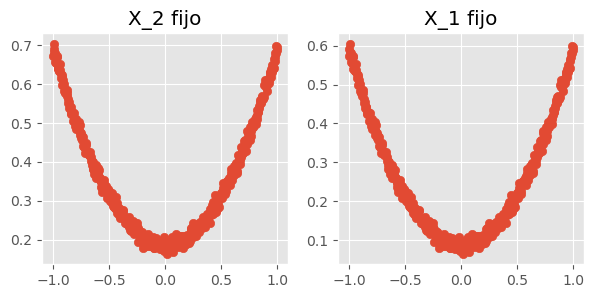

In [2]:
############## GENERACIÓN DE LOS DATOS
n_samples = 500
## Se genera el noise
noise_constant = 0.01
noise = np.random.normal(0,noise_constant,n_samples)

## Se generan los datos de la X
x_lim = [-1,1]
y_lim = [-1,1]
X_1 = np.linspace(x_lim[0],x_lim[1],n_samples)
X_2 = np.linspace(y_lim[0],y_lim[1],n_samples)

def f_output(x1,x_2,noise):
    return 0.5*x1**2 + 0.5*x_2**2+ noise
    #return np.exp(x1) + np.exp(x_2) + noise
Y = f_output(X_1,X_2,noise)
print('La función es: Y = X_1^2 + X_2^2 + noise')
### Vamos a comprobar como es monótona decreciente(creciente) al fijar los valores de X_2(X_1)


X_2_fijo = np.repeat(random.choice(X_2),n_samples)
X_1_fijo = np.repeat(random.choice(X_1),n_samples)

Y_X2_fijo = f_output(X_1,X_2_fijo,noise)
Y_X1_fijo = f_output(X_1_fijo,X_2,noise)


fig, axes = plt.subplots(1,2,figsize=(7,3))
axes[0].scatter(X_1,Y_X2_fijo) 
axes[0].set_title("X_2 fijo")
axes[1].scatter(X_2,Y_X1_fijo)
axes[1].set_title("X_1 fijo")

In [ ]:
#### VISUALIZACION EN 3D
# Create a grid of (X1, X2) values
X1_grid, X2_grid = np.meshgrid(X_1, X_2)
Z = f_output(X1_grid, X2_grid, 0)  # Compute Z values without noise

# Create a 3D surface plot
trace = go.Surface(x=X1_grid, y=X2_grid, z=Z, colorscale='Viridis')

layout = go.Layout(
    title='3D Surface Plot of Y = X1^2 + X2^2',
    scene=dict(
        xaxis=dict(title='X1'),
        yaxis=dict(title='X2'),
        zaxis=dict(title='Y')
    ),
    width=1000,  # Cambia el ancho de la figura
    height=800
)

fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()


In [4]:
### DATA GENERATION
torch.manual_seed(2023)
np.random.seed(0)

# Crear una cuadrícula de valores que serviran como datos de train
n_samples = 50
x1_values = np.linspace(x_lim[0], x_lim[1], n_samples)
x2_values = np.linspace(y_lim[0], y_lim[1], n_samples)
x1_mesh, x2_mesh = np.meshgrid(x1_values, x2_values)
## Juntamos y convertimos a tensor
mesh = np.hstack((x1_mesh.reshape(-1,1),x2_mesh.reshape(-1,1)))
noise_matr=np.random.multivariate_normal(mean=[0,0], cov=[[0, 0], [0,0]], size=len(mesh))
mesh = mesh+noise_matr
input_mesh = torch.tensor(mesh).float()
noise = np.random.normal(0,noise_constant,len(mesh))


## Convertimos los datos a un dataset para pytorch
y=torch.tensor(f_output(mesh[:,0],mesh[:,1],noise)).reshape(len(mesh),1).float()

## Min max scaler to the output
y_min = torch.min(y)
y_max = torch.max(y)
def min_max_scaler(y,y_min=y_min,y_max=y_max):
    return (y-y_min)/(y_max-y_min)
y = min_max_scaler(y)

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(input_mesh, y, test_size=0.25, random_state=2023)

## Convertimos los datos a un dataset para pytorch
n_samples = len(X_train_tensor)
train_dt = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
train_dataload = DataLoader(train_dt,batch_size=64) # create your dataloader

## Convertimos los datos a un dataset para pytorch
n_samples = len(X_test_tensor)
val_dt = TensorDataset(X_test_tensor,y_test_tensor) # create your datset
val_dataload = DataLoader(val_dt,batch_size=n_samples) # create your dataloader


In [ ]:
## Define values in the z axis
z_values = f_output(x1_mesh, x2_mesh, 0)  # Usamos noise=0 para la superficie
## Min max scaler to z_values
z_values = min_max_scaler(z_values,y_min.numpy(),y_max.numpy())

# Crear Scatter3d para datos de entrenamiento y prueba
scatter_train = go.Scatter3d(
    x=X_train_tensor[:, 0],
    y=X_train_tensor[:, 1],
    z=y_train_tensor[:, 0],
    mode='markers',
    marker=dict(size=4, opacity=0.7, color='blue'),
    name='Train Data'
)

scatter_test = go.Scatter3d(
    x=X_test_tensor[:, 0],
    y=X_test_tensor[:, 1],
    z=y_test_tensor[:, 0],
    mode='markers',
    marker=dict(size=4, opacity=0.7, color='red'),
    name='Test Data'
)

# Crear la superficie para la función subyacente
surface_true = go.Surface(x=x1_mesh, y=x2_mesh, z=z_values, opacity=0.5, colorscale='Blues', name='True Function')

# Crear el gráfico
fig = go.Figure(data=[scatter_train, scatter_test, surface_true])
fig.update_layout(scene=dict(zaxis_title='f(x1, x2)',aspectmode='cube'),
    width=1000,  # Cambia el ancho de la figura
    height=800)
fig.update_coloraxes(showscale=False)
fig.show()

#### MODELLING

------------------ Entrenamiento MONOTONO EN X1 Y EN X2 ------------------
[   0/2000] Train Loss 0.047016, Train Loss Mod 0.047016, Val Loss 0.044581
[   1/2000] Train Loss 0.046794, Train Loss Mod 0.046794, Val Loss 0.044565
[   2/2000] Train Loss 0.046743, Train Loss Mod 0.046743, Val Loss 0.044600
[   3/2000] Train Loss 0.046713, Train Loss Mod 0.046713, Val Loss 0.044607
[   4/2000] Train Loss 0.046690, Train Loss Mod 0.046690, Val Loss 0.044610
[   5/2000] Train Loss 0.046666, Train Loss Mod 0.046666, Val Loss 0.044608
[   6/2000] Train Loss 0.046635, Train Loss Mod 0.046635, Val Loss 0.044596
[   7/2000] Train Loss 0.046588, Train Loss Mod 0.046588, Val Loss 0.044569
[   8/2000] Train Loss 0.046509, Train Loss Mod 0.046509, Val Loss 0.044509
[   9/2000] Train Loss 0.046364, Train Loss Mod 0.046364, Val Loss 0.044380
[  10/2000] Train Loss 0.046088, Train Loss Mod 0.046088, Val Loss 0.044104
[  11/2000] Train Loss 0.045565, Train Loss Mod 0.045565, Val Loss 0.043556
[  12/2000] T

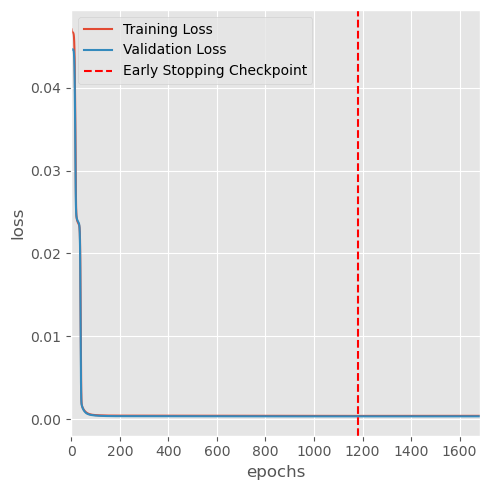

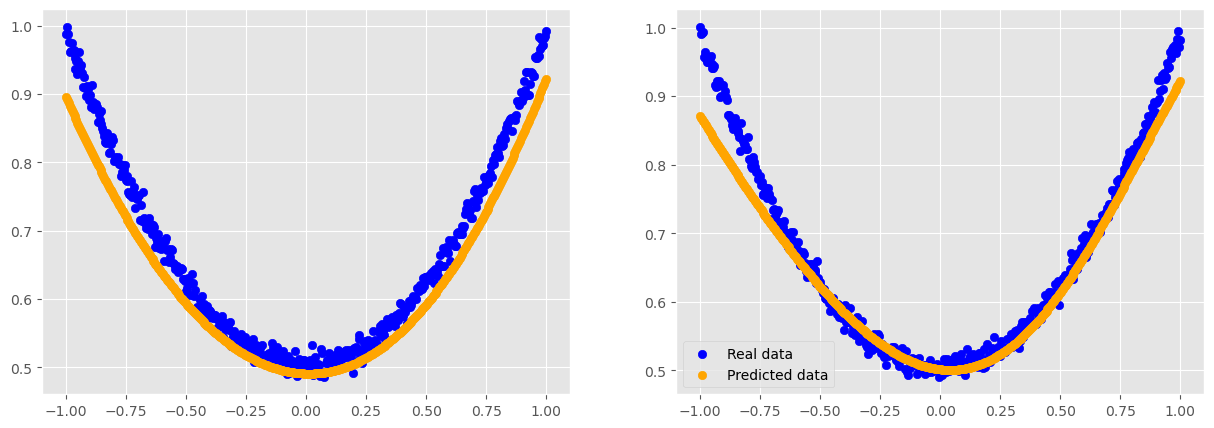

In [5]:
torch.manual_seed(0)

### MODEL DEFINITION ###
#model = MLP_Exponential(in_dim=in_dim,hidden_dim=hidden_dim, out_dim=out_dim)
layers = [2,3,2,1]
actfunc = ['sigmoid','sigmoid']
model = DNN(layers,activations=actfunc)
actfunc.insert(0,'identity')
actfunc.append('identity')

criterion = nn.MSELoss()
monotone_relations =[1,1]

mlp_model = MLP_Monotonic(_model_name="Prueba",_model = model)
print('------------------ Entrenamiento MONOTONO EN X1 Y EN X2 ------------------')

mlp_model.train_adjusted_std(train_data=train_dataload,val_data=val_dataload,criterion=criterion,
                                 n_epochs=2000,categorical_columns=[],verbose=1,n_visualized=1,
                                 monotone_relations=monotone_relations,optimizer_type='Adam',
                                 learning_rate=0.01,weight_decay=1e-4,delta=0.0,patience=500,
                                 delta_synthetic=0.0,delta_external=0.0,std_growth=0.0,epsilon_synthetic=0.0,
                                 model_path='./Models/checkpoint_mlp_',external_points=None,seed=2023)

print('------------------ Resultados Entrenamiento ------------------')
### Ploteado de resultados
mlp_model.plot_history()

## Generamos la matriz de datos de input con un valor fijado en x1 o en x2
fig,axes = plt.subplots(1,2,figsize=(15,5))
n_samples=500
valor_fijo_x2 = 1.0
matr_data = np.linspace((x_lim[0],valor_fijo_x2),(x_lim[1],valor_fijo_x2),n_samples)
matr = matr_data
input_matrix=torch.tensor(matr)
input_matrix=input_matrix.float()
noise = np.random.normal(0,noise_constant,n_samples)
output = f_output(input_matrix[:,0],valor_fijo_x2,noise)
## Min max scaled output 
output_normalized = min_max_scaler(output,y_min.numpy(),y_max.numpy())
axes[0].scatter(input_matrix[:,0],output_normalized, label='Real data',color='blue')
axes[0].scatter(input_matrix[:,0],model(input_matrix).detach().numpy(), label='Predicted data', color='orange')

valor_fijo_x1 = 1.0
matr_data = np.linspace((valor_fijo_x1,y_lim[0]),(valor_fijo_x1,y_lim[1]),n_samples)
matr = matr_data
input_matrix=torch.tensor(matr)
input_matrix=input_matrix.float()
noise = np.random.normal(0,noise_constant,n_samples)
output = f_output(valor_fijo_x1,input_matrix[:,1],noise)
## Min max scaled output 
output_normalized = min_max_scaler(output,y_min.numpy(),y_max.numpy())
axes[1].scatter(input_matrix[:,1],output_normalized, label='Real data',color='blue')
axes[1].scatter(input_matrix[:,1],model(input_matrix).detach().numpy(), label='Predicted data', color='orange')
plt.legend()


In [ ]:
## Extraemos el modelo de la clase
model = mlp_model._model

# Generate the data
n_samples = 200
X1 = np.linspace(x_lim[0], x_lim[1], n_samples)
X2 = np.linspace(y_lim[0], y_lim[1], n_samples)
X1, X2 = np.meshgrid(X1, X2)
matr = np.column_stack((X1.ravel(), X2.ravel()))
input_matrix = torch.tensor(matr, dtype=torch.float32)

# Assuming 'model' is defined and loaded properly, you can now get predictions
with torch.no_grad():
    Y = model(input_matrix).reshape(X1.shape)

# Create a 3D surface plot
trace = go.Surface(x=X1, y=X2, z=Y, colorscale='Viridis')

layout = go.Layout(
    title='3D Surface Plot of the NN',  # Update the title as needed
    scene=dict(
        xaxis=dict(title='X1'),
        yaxis=dict(title='X2'),
        zaxis=dict(title='Y'), aspectmode='cube'
    ),
    width=1000,  # Cambia el ancho de la figura
    height=800
)

fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()


#### VORONOI COMPROBATION

In [6]:
### EXTRACT INFORMATION FOR HESSIAN BOUNDING
weights, biases = utilities_voronoi.get_weights_and_biases(model)
## Take one input and output random (it does not matter since the objetive is to bound the hessian for all input)
x = train_dataload.dataset.tensors[0][0].view(1,-1)
y = train_dataload.dataset.tensors[1][0].view(1,-1)
W, Z, O, D, D2, D_accum, Q, H, counter, mlpstr = calculate_second_partial_derivatives_mlp(weights, biases, actfunc, x, y,sens_end_layer=len(actfunc))
global_lipschitz_constant=utilities_voronoi.hessian_bound(W=W,actfunc=actfunc,partial_monotonic_variable=0,n_variables=2)
print('La constante de Lipschitz es: ',global_lipschitz_constant)

La constante de Lipschitz es:  139.28355404189915


Tiempo de ejecución: 0.004462003707885742


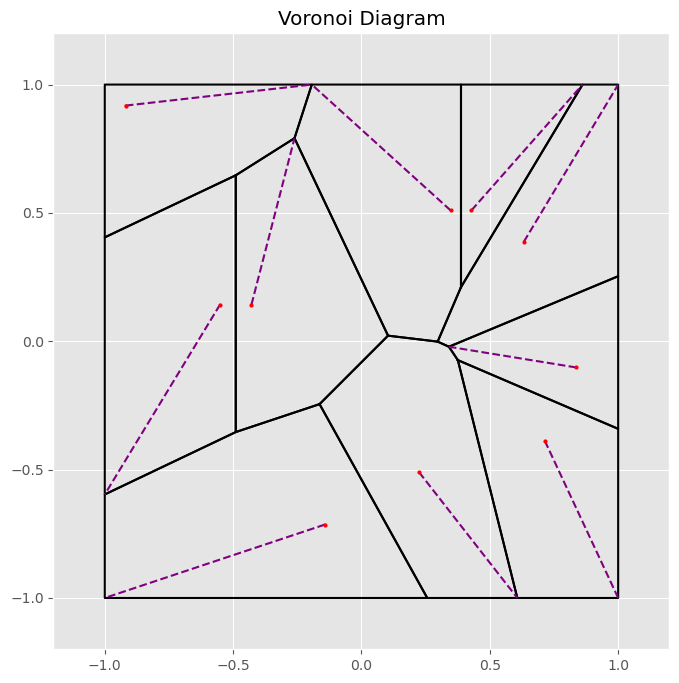

El espacio está relleno: False
The selected vertex is:[ 0.34072762 -0.02129549], corresponding to point [0.63265306 0.3877551 ], and the distance is 0.5025364068430772


In [7]:
##### PLOT VORONOI WITH FURTHEST POINTS #####
importlib.reload(utilities_voronoi)
np.random.seed(0)
torch.manual_seed(0)
# Original points 
## Escogemos n puntos al azar de X_train_tensor
n_points = 10
selected_index = torch.randperm(len(X_train_tensor))[:n_points]
original_points = X_train_tensor[selected_index].numpy()
## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
intervals = [(x_lim[0], x_lim[1]), (y_lim[0], y_lim[1])]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
epsilon = 0.0001
intervals_extended = [(x_lim[0]-epsilon, x_lim[1]+epsilon), (y_lim[0]-epsilon, y_lim[1]+epsilon)]
vertices_extended = utilities_voronoi.generate_hypercube_vertices(intervals_extended)
## Define the coordinates of the square's vertices
square_vertices = np.array([[x_lim[0],y_lim[0]],[x_lim[0],y_lim[1]],[x_lim[1],y_lim[1]],[x_lim[1],y_lim[0]],[x_lim[0],y_lim[0]]])

inputs = torch.tensor(original_points,dtype=torch.float)
## Compute original Voronoi diagram
vor = Voronoi(original_points)

## Compute symmetric points
all_points,_ = utilities_voronoi.add_symmetric_points(vor,vertices_extended,intervals_extended)

## Compute Voronoi diagram with symmetric points (and therefore bounded)
finite_vor = Voronoi(all_points)

## Compute the radios for each point
start_time = time.time()
radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius(inputs=inputs,model=model,global_lipschitz_constant=global_lipschitz_constant,monotone_relation=1,variable_index=[0,1],n_variables=2)
end_time = time.time()
print('Tiempo de ejecución: {}'.format(end_time-start_time))
## Load derivative sign
derivative_sign = [v[1] for k,v in dict_radios.items()]

## Plot Voronoi diagram
utilities_voronoi.plot_finite_voronoi_2D(finite_vor,all_points,original_points,radius_tot,square_vertices,derivative_sign=derivative_sign,plot_symmetric_points=False)

## COMPROBAMOS SI RELLENA EL ESPACIO
space_filled,distances = utilities_voronoi.check_space_filled_vectorized(finite_vor,dict_radios,vertices)
print('El espacio está relleno: {}'.format(space_filled))

if not space_filled:
    selected_vertex = utilities_voronoi.add_new_point_vectorized(finite_vor, vertices, distances, dict_radios)
    ## Project the new point to the hypercube (because of the extension it may be outside the hypercube)
    selected_vertex = utilities_voronoi.proyection_hypercube(selected_vertex, vertices)
    print('The selected vertex is:{}, corresponding to point {}, and the distance is {}'.format(selected_vertex,vor.points[-1],np.linalg.norm(selected_vertex-vor.points[-1])))

In [ ]:
## Plot x_reentrainment
from shapely.geometry import Polygon
boundary_polygon = Polygon(square_vertices)
x,y = boundary_polygon.exterior.xy
plt.plot(x, y, 'b-', label='Inputs Domain')
plt.plot(x_reentrenamiento[:,0].detach().numpy(),x_reentrenamiento[:,1].detach().numpy(),'ro', markersize=2, label='Reentrenamiento')
plt.title('Puntos de reentrenamiento')
plt.legend()

In [ ]:
##### PLOT VORONOI WITH FURTHEST POINTS ##### ########## USANDO NEURALSENS #########
importlib.reload(utilities_voronoi)
np.random.seed(0)
torch.manual_seed(0)
# Original points 
## Escogemos n puntos al azar de X_train_tensor
n_points = 1000
selected_index = torch.randperm(len(X_train_tensor))[:n_points]
original_points = X_train_tensor[selected_index].numpy()
original_points_y = y_train_tensor[selected_index].numpy()
## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
epsilon = 0.0001
intervals = [(x_lim[0]-epsilon, x_lim[1]+epsilon), (y_lim[0]-epsilon, y_lim[1]+epsilon)]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
## Define the coordinates of the square's vertices
square_vertices = np.array([[x_lim[0]-epsilon,y_lim[0]-epsilon],[x_lim[0]-epsilon,y_lim[1]+epsilon],[x_lim[1]+epsilon,y_lim[1]+epsilon],[x_lim[1]+epsilon,y_lim[0]-epsilon],[x_lim[0]-epsilon,y_lim[0]-epsilon]])
inputs = torch.tensor(original_points,dtype=torch.float)
outputs = torch.tensor(original_points_y,dtype=torch.float)
## Compute original Voronoi diagram
vor = Voronoi(original_points)

## Compute symmetric points
all_points = utilities_voronoi.add_symmetric_points(vor,vertices,intervals)

## Compute Voronoi diagram with symmetric points (and therefore bounded)
vor = Voronoi(all_points,incremental=True)

## Compute the radios for each point
start_time = time.time()
radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius_neuralsens(inputs=inputs,outputs=outputs,weights=weights,biases=biases,actfunc=actfunc,global_lipschitz_constant=global_lipschitz_constant,monotone_relation=1,variable_index=[0,1],n_variables=2)
end_time = time.time()
print('Tiempo de ejecución: {}'.format(end_time-start_time))
## Load derivative sign
derivative_sign = [v[1] for k,v in dict_radios.items()]

## Plot Voronoi diagram
utilities_voronoi.plot_finite_voronoi_2D(vor,all_points,original_points,radius_tot,square_vertices,derivative_sign=derivative_sign,plot_symmetric_points=False)

## COMPROBAMOS SI RELLENA EL ESPACIO
space_filled,distances = utilities_voronoi.check_space_filled(vor,radius_tot,vertices)
print('El espacio está relleno: {}'.format(space_filled))


#### RE-ADJUSTMENT

In [ ]:
import copy
torch.manual_seed(0)
np.random.seed(0)
### model -> Contains the last trained model
## Extraemos el modelo de la clase y hacemos una copia a un objeto independiente
model = copy.deepcopy(mlp_model._model)
criterion = nn.MSELoss()
monotone_relations =[1,1]

mlp_model_adjusted = MLP_Monotonic(_model_name="Prueba",_model = model)
print('------------------ Entrenamiento MONOTONO EN X1 Y EN X2 ------------------')

mlp_model_adjusted.train_adjusted_std(train_data=train_dataload,val_data=val_dataload,criterion=criterion,
                                 n_epochs=500,categorical_columns=[],verbose=1,n_visualized=1,
                                 monotone_relations=monotone_relations,optimizer_type='Adam',
                                 learning_rate=0.1,weight_decay=0.00,delta=0.0,patience=500,
                                 delta_synthetic=0.0,delta_external=0.05,std_growth=0.0,epsilon_synthetic=0.0,
                                 model_path='./Models/checkpoint_mlp_adjusted_',external_points=x_reentrenamiento,seed=2023)

print('------------------ Resultados Entrenamiento ------------------')
### Ploteado de resultados
mlp_model_adjusted.plot_history()

## Generamos la matriz de datos de input con un valor fijado en x1 o en x2
fig,axes = plt.subplots(1,2,figsize=(15,5))
n_samples=500
valor_fijo_x2 = 1.0
matr_data = np.linspace((x_lim[0],valor_fijo_x2),(x_lim[1],valor_fijo_x2),n_samples)
matr = matr_data
input_matrix=torch.tensor(matr)
input_matrix=input_matrix.float()
noise = np.random.normal(0,noise_constant,n_samples)
output = f_output(input_matrix[:,0],valor_fijo_x2,noise)
## Min max scaled output 
output_normalized = min_max_scaler(output,y_min.numpy(),y_max.numpy())
axes[0].scatter(input_matrix[:,0],output_normalized, label='Real data',color='blue')
axes[0].scatter(input_matrix[:,0],model(input_matrix).detach().numpy(), label='Predicted data', color='orange')

valor_fijo_x1 = 1.0
matr_data = np.linspace((valor_fijo_x1,y_lim[0]),(valor_fijo_x1,y_lim[1]),n_samples)
matr = matr_data
input_matrix=torch.tensor(matr)
input_matrix=input_matrix.float()
noise = np.random.normal(0,noise_constant,n_samples)
output = f_output(valor_fijo_x1,input_matrix[:,1],noise)
## Min max scaled output 
output_normalized = min_max_scaler(output,y_min.numpy(),y_max.numpy())
axes[1].scatter(input_matrix[:,1],output_normalized, label='Real data',color='blue')
axes[1].scatter(input_matrix[:,1],model(input_matrix).detach().numpy(), label='Predicted data', color='orange')
plt.legend()


In [ ]:
## Extraemos el modelo de la clase
model_adjusted = mlp_model_adjusted._model

# Generate the data
n_samples = 200
X1 = np.linspace(x_lim[0], x_lim[1], n_samples)
X2 = np.linspace(y_lim[0], y_lim[1], n_samples)
X1, X2 = np.meshgrid(X1, X2)
matr = np.column_stack((X1.ravel(), X2.ravel()))
input_matrix = torch.tensor(matr, dtype=torch.float32)

# Assuming 'model' is defined and loaded properly, you can now get predictions
with torch.no_grad():
    Y = model_adjusted(input_matrix).reshape(X1.shape)

# Create a 3D surface plot
trace = go.Surface(x=X1, y=X2, z=Y, colorscale='Viridis')

layout = go.Layout(
    title='3D Surface Plot of the NN',  # Update the title as needed
    scene=dict(
        xaxis=dict(title='X1'),
        yaxis=dict(title='X2'),
        zaxis=dict(title='Y'), aspectmode='cube'
    ),
    width=1000,  # Cambia el ancho de la figura
    height=800
)

fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

In [ ]:
### EXTRACT INFORMATION FOR HESSIAN BOUNDING
## Extract weights and biases from the model
parameters = dict(model_adjusted.state_dict())
weights = []
biases = []
for key, value in parameters.items():
    if 'weight' in key:
        weights.append(value.T)
    elif 'bias' in key:
        biases.append(value)
print('biases', biases)
print('weights', weights)
## Take one input and output random (it does not matter since the objetive is to bound the hessian for all input)
x = train_dataload.dataset.tensors[0][0].view(1,-1)
y = train_dataload.dataset.tensors[1][0].view(1,-1)
W, Z, O, D, D2, D_accum, Q, H, counter, mlpstr = calculate_second_partial_derivatives_mlp(weights, biases, actfunc, x, y,sens_end_layer=len(actfunc))
global_lipschitz_constant=utilities_voronoi.hessian_bound(W=W,actfunc=actfunc,partial_monotonic_variable=0,n_variables=2)
print('La constante de Lipschitz es: ',global_lipschitz_constant)

In [ ]:
##### PLOT VORONOI WITH FURTHEST POINTS #####
importlib.reload(utilities_voronoi)
np.random.seed(0)
torch.manual_seed(0)
# Original points 
## Escogemos n puntos al azar de X_train_tensor
n_points = 1000
selected_index = torch.randperm(len(X_train_tensor))[:n_points]
original_points = X_train_tensor[selected_index].numpy()
## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
intervals = [(x_lim[0], x_lim[1]), (y_lim[0], y_lim[1])]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
epsilon = 0.0001
intervals_extended = [(x_lim[0]-epsilon, x_lim[1]+epsilon), (y_lim[0]-epsilon, y_lim[1]+epsilon)]
vertices_extended = utilities_voronoi.generate_hypercube_vertices(intervals_extended)
## Define the coordinates of the square's vertices
square_vertices = np.array([[x_lim[0],y_lim[0]],[x_lim[0],y_lim[1]],[x_lim[1],y_lim[1]],[x_lim[1],y_lim[0]],[x_lim[0],y_lim[0]]])

inputs = torch.tensor(original_points,dtype=torch.float)
## Compute original Voronoi diagram
vor = Voronoi(original_points)

## Compute symmetric points
all_points = utilities_voronoi.add_symmetric_points(vor,vertices_extended,intervals_extended)

## Compute Voronoi diagram with symmetric points (and therefore bounded)
vor = Voronoi(all_points)

## Compute the radios for each point
start_time = time.time()
radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius(inputs=inputs,model=model_adjusted,global_lipschitz_constant=global_lipschitz_constant,monotone_relation=1,variable_index=[0,1],n_variables=2)
end_time = time.time()
print('Tiempo de ejecución: {}'.format(end_time-start_time))
## Load derivative sign
derivative_sign = [v[1] for k,v in dict_radios.items()]

## Plot Voronoi diagram
utilities_voronoi.plot_finite_voronoi_2D(vor,all_points,original_points,radius_tot,square_vertices,derivative_sign=derivative_sign,plot_symmetric_points=False)

#### CASO f(x,y) = e^x + e^y

In [6]:
################ DATA LOAD  ################
## Load config yaml
with open('../Scripts/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
## Output function definition
def f_output(x1,x_2,noise):
    #return np.exp(x1) + np.exp(x_2) + noise
    return x1 + x_2 + noise
data_load_lipschitz(config, f_output)

X_train_tensor = torch.load('../Data/X_train_data.pt')
X_test_tensor = torch.load('../Data/X_test_data.pt')
y_train_tensor = torch.load('../Data/y_train_data.pt')
y_test_tensor = torch.load('../Data/y_test_data.pt')
## Convertimos los datos a un dataset para pytorch
n_samples = len(X_train_tensor)
train_dt = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
train_dataload = DataLoader(train_dt,batch_size=64) # create your dataloader

## Convertimos los datos a un dataset para pytorch
n_samples = len(X_test_tensor)
val_dt = TensorDataset(X_test_tensor,y_test_tensor) # create your datset
val_dataload = DataLoader(val_dt,batch_size=n_samples) # create your dataloader

In [9]:
#### DATA GENERATION
n_samples = 500
## Se genera el noise
noise_constant = 0.01
noise = np.random.normal(0,noise_constant,n_samples)

## Se generan los datos de la X
x_lim = [-1,1]
y_lim = [-1,1]
## Output function definition
def f_output(x1,x_2,noise):
    #return np.exp(x1) + np.exp(x_2) + noise
    return x1 + x_2 + noise
### DATA GENERATION
torch.manual_seed(2023)
np.random.seed(0)

# Crear una cuadrícula de valores que serviran como datos de train
n_samples = 50
x1_values = np.linspace(x_lim[0], x_lim[1], n_samples)
x2_values = np.linspace(y_lim[0], y_lim[1], n_samples)
x1_mesh, x2_mesh = np.meshgrid(x1_values, x2_values)
## Juntamos y convertimos a tensor
mesh = np.hstack((x1_mesh.reshape(-1,1),x2_mesh.reshape(-1,1)))
noise_matr=np.random.multivariate_normal(mean=[0,0], cov=[[0, 0], [0,0]], size=len(mesh))
mesh = mesh+noise_matr
input_mesh = torch.tensor(mesh).float()
noise = np.random.normal(0,noise_constant,len(mesh))


## Convertimos los datos a un dataset para pytorch
y=torch.tensor(f_output(mesh[:,0],mesh[:,1],noise)).reshape(len(mesh),1).float()

## Min max scaler to the output
y_min = torch.min(y)
y_max = torch.max(y)
def min_max_scaler(y,y_min=y_min,y_max=y_max):
    return (y-y_min)/(y_max-y_min)
y = min_max_scaler(y)

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(input_mesh, y, test_size=0.25, random_state=2023)

## Convertimos los datos a un dataset para pytorch
n_samples = len(X_train_tensor)
train_dt = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
train_dataload = DataLoader(train_dt,batch_size=64) # create your dataloader

## Convertimos los datos a un dataset para pytorch
n_samples = len(X_test_tensor)
val_dt = TensorDataset(X_test_tensor,y_test_tensor) # create your datset
val_dataload = DataLoader(val_dt,batch_size=n_samples) # create your dataloader

In [10]:
## Define values in the z axis
z_values = f_output(x1_mesh, x2_mesh, 0)  # Usamos noise=0 para la superficie
## Min max scaler to z_values
z_values = min_max_scaler(z_values,y_min.numpy(),y_max.numpy())

# Crear Scatter3d para datos de entrenamiento y prueba
scatter_train = go.Scatter3d(
    x=X_train_tensor[:, 0],
    y=X_train_tensor[:, 1],
    z=y_train_tensor[:, 0],
    mode='markers',
    marker=dict(size=4, opacity=0.7, color='blue'),
    name='Train Data'
)

scatter_test = go.Scatter3d(
    x=X_test_tensor[:, 0],
    y=X_test_tensor[:, 1],
    z=y_test_tensor[:, 0],
    mode='markers',
    marker=dict(size=4, opacity=0.7, color='red'),
    name='Test Data'
)

# Crear la superficie para la función subyacente
surface_true = go.Surface(x=x1_mesh, y=x2_mesh, z=z_values, opacity=0.5, colorscale='Blues', name='True Function')

# Crear el gráfico
fig = go.Figure(data=[scatter_train, scatter_test, surface_true])
fig.update_layout(scene=dict(zaxis_title='f(x1, x2)',aspectmode='cube'),
    width=1000,  # Cambia el ancho de la figura
    height=800)
fig.update_coloraxes(showscale=False)
fig.show()

{'data_load': {'n_samples': 8, 'noise_constant': 0.05, 'x_lim': [0, 1], 'y_lim': [0, 1.0]}, 'model_architecture': {'actfunc': ['sigmoid'], 'batch_size': None, 'layers': [2, 10, 1]}, 'training': {'delta': 0.5, 'delta_external': 0.0, 'delta_synthetic': 0.0, 'epsilon_synthetic': 0.0, 'learning_rate': 0.01, 'monotone_relations': [0, 0], 'n_epochs': 5000, 'patience': 100, 'plot_history': True, 'save_model': False, 'std_growth': 0.0, 'verbose': 1, 'weight_decay': 2e-06, 'seed': 0, 'optimizer_type': 'Adam'}}
------------------ Training ------------------
[   0/5000] Train Loss 0.788111, Train Loss Mod 0.788111, Val Loss 0.579205
[   1/5000] Train Loss 0.678148, Train Loss Mod 0.678148, Val Loss 0.487444
[   2/5000] Train Loss 0.578159, Train Loss Mod 0.578159, Val Loss 0.405483
[   3/5000] Train Loss 0.487982, Train Loss Mod 0.487982, Val Loss 0.333063
[   4/5000] Train Loss 0.407358, Train Loss Mod 0.407358, Val Loss 0.269906
[   5/5000] Train Loss 0.336017, Train Loss Mod 0.336017, Val Loss

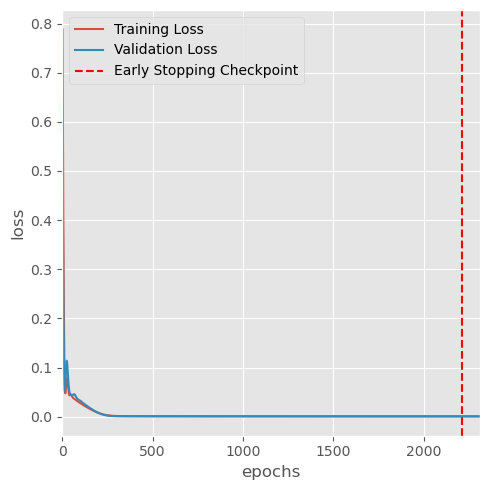

In [11]:
### CON PENALIZACION
torch.manual_seed(0)
with open('../Scripts/config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
print(config)
NN_Monotonic = train(config)
model = NN_Monotonic._model

In [12]:
## Extract weights and biases from the model
parameters = dict(model.state_dict())
weights = []
biases = []
for key, value in parameters.items():
    if 'weight' in key:
        weights.append(value.T)
    elif 'bias' in key:
        biases.append(value)
print('biases', biases)
print('weights', weights)
## Take one input and output random (it does not matter since the objetive is to bound the hessian for all input)
x = train_dataload.dataset.tensors[0][0].view(1,-1)
y = train_dataload.dataset.tensors[1][0].view(1,-1)
W, Z, O, D, D2, D_accum, Q, H, counter, mlpstr = calculate_second_partial_derivatives_mlp(weights, biases, config['model_architecture']['actfunc'], x, y,sens_end_layer=len(config['model_architecture']['actfunc']))
global_lipschitz_constant=utilities_voronoi.hessian_bound(W=W,actfunc=config['model_architecture']['actfunc'],partial_monotonic_variable=0,n_variables=2)
print('La constante de Lipschitz es: ',global_lipschitz_constant)

biases [tensor([ 0.2839, -0.0628, -2.5644,  0.2938, -1.4708, -0.0852, -0.4485, -0.2076,
        -0.0940, -0.1869]), tensor([0.1148])]
weights [tensor([[-1.0230e+00,  6.1981e-01,  1.8238e+00,  3.5803e-01,  4.3507e-01,
          1.3935e+00,  8.8482e-02,  7.0502e-01, -6.4651e-01,  1.6068e-03],
        [-3.9278e-01,  7.2155e-01,  1.1711e+00,  6.4823e-01,  1.3268e+00,
          1.9333e-02,  1.0767e+00, -1.0610e+00, -8.3454e-01, -1.7107e-01]]), tensor([[-0.4198],
        [ 0.1668],
        [ 0.4619],
        [ 0.1346],
        [ 0.3308],
        [ 0.3428],
        [ 0.2150],
        [-0.1608],
        [-0.6001],
        [-0.0084]])]
La constante de Lipschitz es:  2.4788904531305977


In [12]:
## Antes obtenía 4.313047891745562 

-0.0007593952312445751

Tiempo de ejecución: 0.006470203399658203


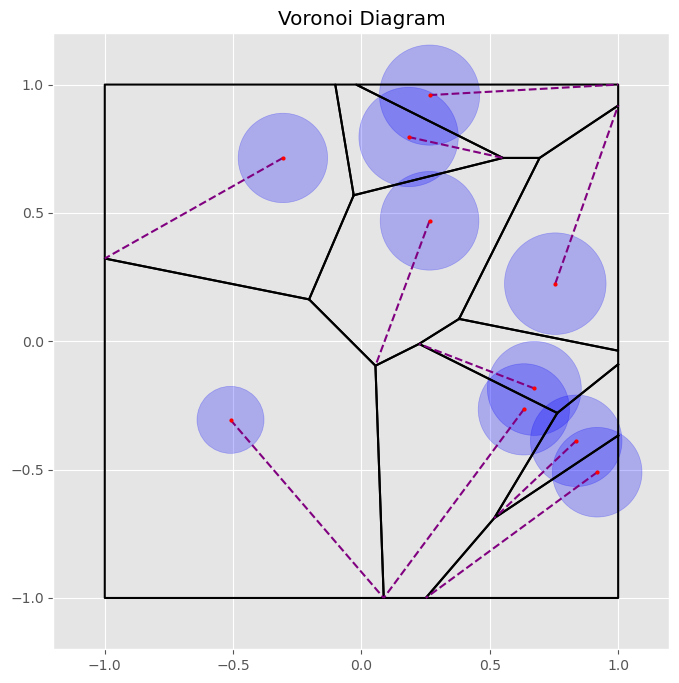

El espacio está relleno: False


In [13]:
##### PLOT VORONOI WITH FURTHEST POINTS #####
torch.manual_seed(1)
np.random.seed(1)
## Escogemos n puntos al azar de X_train_tensor
n_points = 10
selected_index = torch.randperm(len(X_train_tensor))[:n_points]
original_points = X_train_tensor[selected_index].numpy()
inputs = torch.tensor(original_points,dtype=torch.float)


## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
epsilon = 0.0001
intervals = [(x_lim[0], x_lim[1]), (y_lim[0], y_lim[1])]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
intervals_extended = [(x_lim[0]-epsilon, x_lim[1]+epsilon), (y_lim[0]-epsilon, y_lim[1]+epsilon)]
vertices_extended = utilities_voronoi.generate_hypercube_vertices(intervals_extended)
## Define the coordinates of the square's vertices
square_vertices = np.array([[x_lim[0],y_lim[0]],[x_lim[0],y_lim[1]],[x_lim[1],y_lim[1]],[x_lim[1],y_lim[0]],[x_lim[0],y_lim[0]]])


## Compute original Voronoi diagram
original_vor = Voronoi(original_points,incremental=True)

## Compute symmetric points
all_points,_ = utilities_voronoi.add_symmetric_points(original_vor,vertices_extended,intervals_extended)

## Compute Voronoi diagram with symmetric points (and therefore bounded)
finite_vor = Voronoi(all_points,incremental=True)

## Compute the radios for each point
start_time = time.time()
radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius(inputs=inputs,model=model,
                                                                                  global_lipschitz_constant=global_lipschitz_constant,monotone_relation=1,variable_index=[0,1],n_variables=2)
end_time = time.time()
print('Tiempo de ejecución: {}'.format(end_time-start_time))
## Load derivative sign
derivative_sign = [v[1] for k,v in dict_radios.items()]

## Plot Voronoi diagram
utilities_voronoi.plot_finite_voronoi_2D(finite_vor,all_points,original_points,radius_tot,square_vertices,derivative_sign=derivative_sign,plot_symmetric_points=False)

## Check if the space is filled
space_filled,distances = utilities_voronoi.check_space_filled_vectorized(finite_vor,dict_radios,vertices)
print('El espacio está relleno: {}'.format(space_filled))

Using NeuralSens
The space is filled: True after 136 iterations 


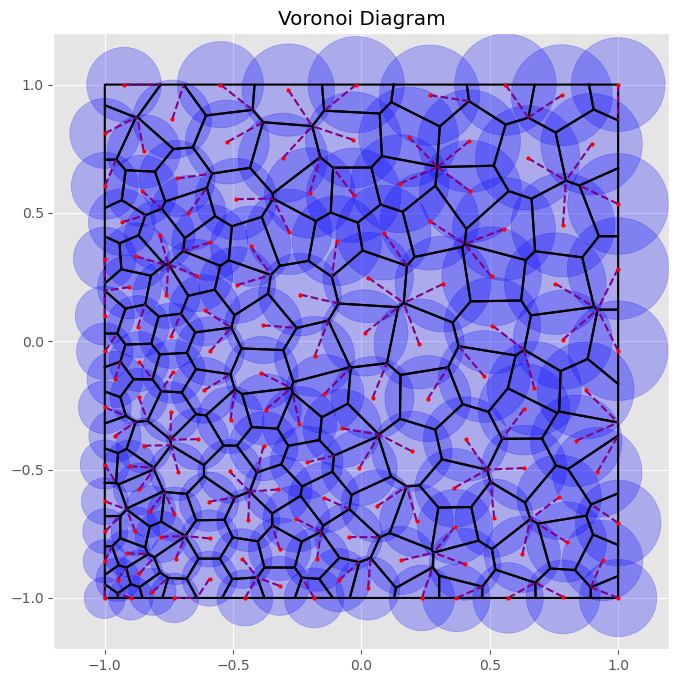

In [14]:
## Add points to the Voronoi diagram
importlib.reload(utilities_voronoi)
#utilities_voronoi.add_points_to_voronoi(original_vor,original_points,finite_vor,dict_radios,vertices,distances,model,global_lipschitz_constant,x_lim,y_lim,monotone_relations=1,variable_index=[0,1],n_variables=2,plot_voronoi=False,epsilon=1e-5,max_iterations=10000)
utilities_voronoi.add_points_to_voronoi(original_vor=original_vor,original_points=original_points,finite_vor=finite_vor,dict_radios=dict_radios,
                                        vertices=vertices,distances=distances,model=model,global_lipschitz_constant=global_lipschitz_constant,
                                        actfunc=config['model_architecture']['actfunc'],intervals=intervals,monotone_relations=1,variable_index=[0,1],
                                        n_variables=2,plot_voronoi=False,epsilon=1e-5,max_iterations=1000)


#### HESSIAN BOUND GRID

In [ ]:
### DATA LOAD
## Load config yaml
with open('../Scripts/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
## Output function definition
def f_output(x1,x_2,noise):
    return np.exp(x1) + np.exp(x_2) + noise
data_load_lipschitz(config, f_output)

X_train_tensor = torch.load('../Data/X_train_data.pt')
X_test_tensor = torch.load('../Data/X_test_data.pt')
y_train_tensor = torch.load('../Data/y_train_data.pt')
y_test_tensor = torch.load('../Data/y_test_data.pt')
## Convertimos los datos a un dataset para pytorch
n_samples = len(X_train_tensor)
train_dt = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
train_dataload = DataLoader(train_dt,batch_size=64) # create your dataloader

## Convertimos los datos a un dataset para pytorch
n_samples = len(X_test_tensor)
val_dt = TensorDataset(X_test_tensor,y_test_tensor) # create your datset
val_dataload = DataLoader(val_dt,batch_size=n_samples) # create your dataloader

In [ ]:
layers_options = {1:[2,3,1],2:[2,5,1],3:[2,10,1],4:[2,20,1],
                  5:[2,3,3,1],6:[2,3,5,1],7:[2,3,10,1],8:[2,3,20,1],
                  9:[2,3,3,3,1],10:[2,3,5,3,1],11:[2,3,5,10,1],12:[2,3,5,20,1],
                  13:[2,3,3,3,3,1],14:[2,3,5,3,3,1],15:[2,3,5,10,3,1],16:[2,3,5,20,3,1]}
## iterate over the different values of the dictionary
for l in layers_options.values():
    print(l)

In [ ]:
torch.manual_seed(2024)
### HESSIAN BOUND ESTIMATION
for seed in [0,1,2,3,4]:
    for l in layers_options.values():
        ## Load config yaml
        with open('../Scripts/config.yaml') as file:
            config = yaml.load(file, Loader=yaml.FullLoader)
        # Actualizar el diccionario de configuración con los valores actuales
        config['training']['seed'] = seed
        config['model_architecture']['layers'] = l
        ## If the model has more than 2 layers, we need to add the activation function
        if len(l)==4:
            config['model_architecture']['actfunc'] = ['sigmoid','sigmoid']
        elif len(l)==5:
            config['model_architecture']['actfunc'] = ['sigmoid','sigmoid','sigmoid']

        ### TRAINING
        NN_Monotonic = train(config)
        
        ## COMPUTE GLOBAL LIPSCHITZ CONSTANT
        parameters = dict(NN_Monotonic._model.state_dict())
        weights = []
        biases = []
        for key, value in parameters.items():
            if 'weight' in key:
                weights.append(value.T)
            elif 'bias' in key:
                biases.append(value)
        ## Take one input and output random (it does not matter since the objetive is to bound the hessian for all input)
        x = train_dataload.dataset.tensors[0][0].view(1,-1)
        y = train_dataload.dataset.tensors[1][0].view(1,-1)
        W, Z, O, D, D2, D_accum, Q, H, counter, mlpstr = calculate_second_partial_derivatives_mlp(weights, biases, config['model_architecture']['actfunc'], x, y,sens_end_layer=len(config['model_architecture']['actfunc']))
        global_lipschitz_constant=utilities_voronoi.hessian_bound(W=W,actfunc=config['model_architecture']['actfunc'],partial_monotonic_variable=0,n_variables=2)

        ### Print Results
        Utils.print_errors(NN_Monotonic._model,X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor,np.round(global_lipschitz_constant,3),log=True,config=config)

In [ ]:
### Read Logs csv file
logs = pd.read_csv('..\logs\errors_log_old.csv')
# First convert logs['layers'] from list of string to list of intergers
logs['Layers'] = logs['Layers'].apply(lambda x: [int(i) for i in x.strip('[]').split(',')])

## Define N_Neurons as a new column as the sum of Layers columns [2,3,1] -> 6
logs['N_Neurons'] = logs['Layers'].apply(lambda x: sum(x))
## Generate a column with the number of layers
logs['N_Layers'] = logs['Layers'].apply(lambda x: len(x))
## Convert MAE_Test column to float
logs['MAE_Test'] = logs['MAE_Test'].apply(lambda x: float(x))
logs.head()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Assuming 'MAE_test' is the variable you want to use for color
# Adjust the cmap as per your preference
cmap = sns.cm.rocket_r  # You can choose a different colormap

# GRAPHIC VISUALIZATION
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Plot for the first subplot
scatter1 = sns.scatterplot(data=logs, x='N_Neurons', y='lipschitz_const', hue='MAE_Test', palette=cmap, ax=axes[0], legend=False)

# Change log scale
axes[0].set_yscale('log')

# Create a ScalarMappable for the color mapping
sm1 = ScalarMappable(cmap=cmap)
sm1.set_array(logs['MAE_Test'])

# Add a colorbar for the first subplot
colorbar1 = plt.colorbar(sm1, ax=axes[0])
colorbar1.set_label('MAE_Test')

# Plot for the second subplot
scatter2 = sns.scatterplot(data=logs, x='N_Layers', y='lipschitz_const', hue='MAE_Test', palette=cmap, ax=axes[1], legend=False)

# Change log scale
axes[1].set_yscale('log')

# Create a ScalarMappable for the color mapping
sm2 = ScalarMappable(cmap=cmap)
sm2.set_array(logs['MAE_Test'])

# Add a colorbar for the second subplot
colorbar2 = plt.colorbar(sm2, ax=axes[1])
colorbar2.set_label('MAE_Test')

plt.show()


#### EXTRA -> VORONOI EXAMPLE

In [ ]:
###### EJEMPLO PARA CONDICIÓN DE PARADO
original_points = np.array([[-0.3,-0.5],[-0.5,0.5],[0.5,-0.5],[0.5,0.5]])
## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
intervals = [(x_lim[0], x_lim[1]), (y_lim[0], y_lim[1])]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
## Define the coordinates of the square's vertices
square_vertices = np.array([[x_lim[0],y_lim[0]],[x_lim[0],y_lim[1]],[x_lim[1],y_lim[1]],[x_lim[1],y_lim[0]],[x_lim[0],y_lim[0]]])
inputs = torch.tensor(original_points,dtype=torch.float)
## Compute original Voronoi diagram
original_vor = Voronoi(original_points,incremental=True)

## Compute symmetric points
all_points = utilities_voronoi.add_symmetric_points(original_vor,vertices,intervals)

## Compute Voronoi diagram with symmetric points (and therefore bounded)
finite_vor = Voronoi(all_points,incremental=True)

radius_tot = [0.72,0.72,0.72,0.53]
## Load derivative sign
derivative_sign = [1 for i in range(len(radius_tot))]

## Plot Voronoi diagram
utilities_voronoi.plot_finite_voronoi_2D(finite_vor,all_points,original_points,radius_tot,square_vertices,derivative_sign=derivative_sign,plot_symmetric_points=False)

## Check if the space is filled
space_filled,distances = utilities_voronoi.check_space_filled(finite_vor,radius_tot,vertices)
print('El espacio está relleno: {}'.format(space_filled))


In [ ]:
def add_points_to_voronoi_check(original_vor, original_points, finite_vor, radius_tot, vertices, distances, x_lim, y_lim,plot_voronoi=False, epsilon=1e-5, max_iterations=10):
    """ESTA FUNCIÓN SOLO SIRVE PARA COMPROBAR QUE add_points_to_voronoi FUNCIONA CORRECTAMENTE 
    """
    ## Define the coordinates of the square's vertices
    square_vertices = np.array([[x_lim[0], y_lim[0]], [x_lim[0], y_lim[1]], [x_lim[1], y_lim[1]], [x_lim[1], y_lim[0]], [x_lim[0], y_lim[0]]])

    ## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval with the given extension
    intervals_extended = [(x_lim[0] - epsilon, x_lim[1] + epsilon), (y_lim[0] - epsilon, y_lim[1] + epsilon)]
    vertices_extended = utilities_voronoi.generate_hypercube_vertices(intervals_extended)

    for i in range(max_iterations):
        ## Add new point
        selected_vertex = utilities_voronoi.add_new_point(finite_vor, vertices, distances, radius_tot)
        ## Project the new point to the hypercube (because of the extension it may be outside the hypercube)
        selected_vertex = utilities_voronoi.proyection_hypercube(selected_vertex, vertices)
        ## Add the new point to the original points
        original_points = np.vstack((original_points, selected_vertex))
        ## Add the new point to the inputs
        inputs = torch.tensor(original_points, dtype=torch.float)
        ## Add the new point to the Voronoi diagram
        original_vor.add_points(selected_vertex.reshape(1, -1))
        ## Compute the new finite Voronoi diagram with the new point
        all_points = utilities_voronoi.add_symmetric_points(original_vor, vertices_extended, intervals_extended)
        finite_vor = Voronoi(all_points, incremental=True)
        ## Compute the new radios for each point
        radius_tot.append(0.53)
        derivative_sign = [1 for i in range(len(radius_tot))]
        ## Plot Voronoi diagram
        if plot_voronoi:
            utilities_voronoi.plot_finite_voronoi_2D(vor=finite_vor, all_points=all_points, original_points=original_points, radios=radius_tot, boundary=square_vertices, derivative_sign=derivative_sign, plot_symmetric_points=False)
        ## Check if the space is filled
        i += 1
        space_filled, distances = utilities_voronoi.check_space_filled(finite_vor, radius_tot, vertices)
        print('El espacio está relleno: {}'.format(space_filled))
        if space_filled:
            break

    return original_points

In [ ]:
#### EXAMPLE OF USE
original_points = add_points_to_voronoi_check(original_vor, original_points, finite_vor, radius_tot, vertices, distances, x_lim, y_lim,plot_voronoi=True, epsilon=1e-5, max_iterations=10)


In [ ]:
################ PROBLEMA -> LOS FURTHEST VERTEX EN CADA ITERACIÓN SE ESCOGEN EN LA FRONTERA LUEGO HABRÍA QUE IR AMPLIANDO EL EPSILON
### Start from a  trained Voronoi with the symmetric points
# This is important so the voronoi has the infinite and finite region well defined for the find of furthest vertices
intervals = [(x_lim[0], x_lim[1]), (y_lim[0], y_lim[1])]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
square_vertices = np.array([[x_lim[0],y_lim[0]],[x_lim[0],y_lim[1]],[x_lim[1],y_lim[1]],[x_lim[1],y_lim[0]],[x_lim[0],y_lim[0]]])

## Vertices with small extension are also added so boundary points can have symmetric points
epsilon = 1e-5
intervals_extended = [(x_lim[0]-epsilon, x_lim[1]+epsilon), (y_lim[0]-epsilon, y_lim[1]+epsilon)]
vertices_extended = utilities_voronoi.generate_hypercube_vertices(intervals_extended)
##Define square vertices with the extension
square_vertices_extended = np.array([[x_lim[0]-epsilon,y_lim[0]-epsilon],[x_lim[0]-epsilon,y_lim[1]+epsilon],[x_lim[1]+epsilon,y_lim[1]+epsilon],[x_lim[1]+epsilon,y_lim[0]-epsilon],[x_lim[0]-epsilon,y_lim[0]-epsilon]])

for i in range(10):
    selected_vertex = utilities_voronoi.add_new_point(finite_vor,vertices,distances,radius_tot)
    print('Antes',selected_vertex)
    ## Proyectamos el vertice seleccionado para que esté dentro del hypercubo (Al considerar la simetría, el vertice seleccionado puede estar fuera del hypercubo) _> REVISAR!!!!
    selected_vertex = utilities_voronoi.proyection_hypercube(selected_vertex,vertices)
    print('Despues',selected_vertex)
    ## Juntamos los puntos originales con los nuevos
    original_points = np.vstack((original_points,selected_vertex))
    # Original points 
    ## Escogemos n puntos al azar de X_train_tensor
    inputs = torch.tensor(original_points,dtype=torch.float)
    ## Compute original Voronoi diagram
    original_vor.add_points(selected_vertex.reshape(1,-1))

    ## Compute symmetric points
    all_points = utilities_voronoi.add_symmetric_points(original_vor,vertices_extended,intervals_extended)

    ## Compute Voronoi diagram with symmetric points (and therefore bounded)
    finite_vor = Voronoi(all_points,incremental=True)

    radius_tot.append(0.5)
    ## Load derivative sign
    derivative_sign = [1 for i in range(len(radius_tot))]

    ## Plot Voronoi diagram
    utilities_voronoi.plot_finite_voronoi_2D(vor=finite_vor,all_points=all_points,original_points=original_points,radios=radius_tot,boundary=square_vertices,derivative_sign=derivative_sign,plot_symmetric_points=False)
    i+=1
    ## Check if the space is filled and in that case stop
    space_filled,distances = utilities_voronoi.check_space_filled(finite_vor,radius_tot,vertices)
    #print('El espacio está relleno: {}'.format(space_filled))
    if space_filled:
        break

In [ ]:
### COMPROBACIÓN DE SI EL ESPACIO ESTÁ LLENO Y EN CASO CONTRARIO AÑADIR PUNTOS


In [ ]:
#### EJEMPLO DE CÁCLULO COMPROBACIÓN TORCH AUTOGRAD Y NEURALSENS

### CALCULO MEDIANTE AUTOGRAD 
x = inputs[1]

input = x.clone().detach().requires_grad_(True)
# Realiza una pasada hacia adelante para calcular la salida del modelo en 'x'
output = model(input)
# Calcula la derivada
output.backward()
# La derivada con respecto a 'x' ahora se encuentra en x.grad
derivative_autograd = input.grad
derivative_autograd

### CALCULO MEDIANTE NEURALSENS
### FIRTS PARTIAL DERIVATIVES
W, Z, O, D, D_accum, counter, mlpstr = calculate_first_partial_derivatives_mlp(weights, biases, actfunc, x.view(-1,2), y_train_tensor[0].view(-1,1),sens_end_layer=len(actfunc))
print('Autograd Derivative',derivative_autograd)
print('NeuralSens Derivative',D_accum[2].reshape(-2))

In [ ]:
#################### REPRESENTACIÓN SIN LOS SIMÉTRICOS  ####################
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
torch.manual_seed(0)
original_points = X_train_tensor[torch.randperm(len(X_train_tensor))[:3]].numpy()
original_points = np.array([[0.9183673 , 0.4489796 ],
       [0.85714287, 0.30612245],
       [0.0,0.5]])
# Compute the Voronoi diagram
vor = Voronoi(original_points)

# Plot the Voronoi diagram
voronoi_plot_2d(vor)
boundary=square_vertices
boundary_polygon = Polygon(boundary)
x,y = boundary_polygon.exterior.xy
plt.plot(x, y, 'b-', label='Square')
plt.xlim([x_lim[0]-0.1,x_lim[1]+0.1])
plt.ylim([y_lim[0]-0.1,y_lim[1]+0.1])
plt.show()

In [ ]:
original_points

In [ ]:
# DIBUJAMOS EL JACOBIANO
model = mlp_model._model
# Generate the data
n_samples = 3
X1 = np.linspace(x_lim[0], x_lim[1], n_samples)
X2 = np.linspace(y_lim[0], y_lim[1], n_samples)
X1, X2 = np.meshgrid(X1, X2)
matr = np.column_stack((X1.ravel(), X2.ravel()))
input_matrix = torch.tensor(matr, dtype=torch.float32)

# Assuming 'model' is defined and loaded properly, you can now get predictions
with torch.no_grad():
    Y = model(input_matrix).reshape(X1.shape)
mlp_model._plot_jacobian_interactive(input_matrix,0,1,0)
mlp_model._plot_jacobian_interactive(input_matrix,0,1,1)

In [ ]:
############################   REENTRENAMIENTO                       ####################################################
print('------------------ REENTRENAMIENTO ------------------')
torch.manual_seed(0)
############# CORREGIRLO PARA QUE SOLO ACTUEN EN LA VARIABLE 1 LA CONDICION MONOTONA
model = mlp_model._model
mlp_adjusted = MLP_Monotonic(_model_name="Prueba",_model = model)
monotone_relations = [1,1] ## Añadimos la condicion monótona
external_points = x_reentrenamiento
mlp_adjusted.train_adjusted_std(train_data=train_dataload,val_data=val_dataload,criterion=criterion,
                                 n_epochs=300,categorical_columns=[],verbose=1,n_visualized=1,
                                 monotone_relations=monotone_relations,optimizer_type='Adam',
                                 learning_rate=0.01,delta=0.5,patience=300,external_points=external_points,
                                 delta_synthetic=0.0,delta_external=0.3,std_growth=0.0,epsilon_synthetic=0.0,
                                 model_path='./Models/checkpoint_mlp_',seed=2023)

print('------------------ Resultados Entrenamiento ------------------')
### Ploteado de resultados
mlp_adjusted.plot_history()


In [ ]:
# Generate the data
n_samples = 200
X1 = np.linspace(x_lim[0], x_lim[1], n_samples)
X2 = np.linspace(y_lim[0], y_lim[1], n_samples)
X1, X2 = np.meshgrid(X1, X2)
matr = np.column_stack((X1.ravel(), X2.ravel()))
input_matrix = torch.tensor(matr, dtype=torch.float32)
model = mlp_adjusted._model
# Assuming 'model' is defined and loaded properly, you can now get predictions
with torch.no_grad():
    Y = model(input_matrix).reshape(X1.shape)

# Create a 3D surface plot
trace = go.Surface(x=X1, y=X2, z=Y, colorscale='Viridis')

layout = go.Layout(
    title='3D Surface Plot of Y = F(X1, X2)',  # Update the title as needed
    scene=dict(
        xaxis=dict(title='X1'),
        yaxis=dict(title='X2'),
        zaxis=dict(title='Y')
    ),
    width=1000,  # Cambia el ancho de la figura
    height=800
)

fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

In [ ]:
# DIBUJAMOS EL JACOBIANO

# Generate the data
n_samples = 3
X1 = np.linspace(-0.5, 2.0, n_samples)
X2 = np.linspace(-0.5, 2.0, n_samples)
X1, X2 = np.meshgrid(X1, X2)
matr = np.column_stack((X1.ravel(), X2.ravel()))
input_matrix = torch.tensor(matr, dtype=torch.float32)

# Assuming 'model' is defined and loaded properly, you can now get predictions
with torch.no_grad():
    Y = model(input_matrix).reshape(X1.shape)
mlp_adjusted._plot_jacobian_interactive(input_matrix,0,1,0)

In [ ]:
print('------------------ COMPROBACIÓN EN UN CONJUNTO DE PUNTOS ------------------')

points = np.array([[-0.50,1.50],[-0.30,1.0],[0.70,1.0],[1.0,1.0],[1.50,1.0]])
## Frontera
boundary = np.array([[-1.0,-1.0],[-1.0,2.0],[2.0,2.0],[2.0,-1.0]])
inputs = torch.tensor(points,dtype=torch.float)

radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius(inputs,model,global_lipschitz_constant)

print('Puntos con reentrenamiento necesario: ',x_reentrenamiento)
vor = Voronoi(points, furthest_site=False,incremental=True)

dists = utilities_voronoi.plot_voronoi_with_all_vertices(vor, boundary,dict_radios)

In [ ]:
## Añadiendo de forma secuencial nuevos puntos
np.random.seed(seed=0)
print('------ VORONOI INICIAL ------')
### HAY QUE VOLVER A CALCULAR EL VORONOI

dists = utilities_voronoi.plot_voronoi_with_all_vertices(vor, boundary, dict_radios)
for i in range(100):
    ### AÑADIENDO UN NUEVO PUNTO AL VORONOI DIAGRAM
    new_point = utilities_voronoi.add_new_point_polygon_optimized(vor, dists, radius_tot,boundary)
    vor.add_points([new_point])
    input = torch.tensor(new_point,dtype=torch.float).reshape(-1,2)
    input.requires_grad = True
    inputs = torch.cat((inputs,input),dim=0)
    radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius(inputs,model,global_lipschitz_constant)
    
dists = utilities_voronoi.plot_voronoi_with_all_vertices(vor, boundary, dict_radios)

#######################################################################3 COMPROBAR QUE LOS RADIOS Y LAS DISTANCIAS COINCIDEN ELEMENTO A ELEMENTO
if all(radius > dist for radius, dist in zip(radius_tot, dists)):
    print("El espacio está relleno.")
else:
    print("El espacio no está relleno.")

In [ ]:
def filtrar_puntos_cuadrado(x1, y1, x2, y2, puntos):
    puntos_filtrados = []
    for punto in puntos:
        x, y = punto
        if x1 <= x <= x2 and y1 <= y <= y2:
            puntos_filtrados.append(punto)
    return puntos_filtrados

# Ejemplo de uso
cuadrado = (0, 0, 5, 5)  # Cuadrado con coordenadas (0, 0) y (5, 5)
puntos = torch.tensor([(1, 1), (-1, 2), (2, 3), (4, 4), (0, 0)])

puntos_filtrados = filtrar_puntos_cuadrado(*cuadrado, puntos)
print("Puntos dentro del cuadrado:", puntos_filtrados)


In [ ]:
print('------------------ COMPROBACIÓN EN UN CONJUNTO DE PUNTOS ------------------')

#points = torch.cat((X_train_tensor,external_points),dim=0).detach().numpy()

cuadrado = (-0.5, -0.5, 2.0, 2.0)  # Cuadrado 
puntos_filtrados = filtrar_puntos_cuadrado(*cuadrado, X_train_tensor) ### Necesario para que no de error
points = torch.stack(puntos_filtrados).detach().numpy()
#points = X_train_tensor[1:100].detach().numpy()
## Frontera
boundary = np.array([[-0.5,-0.5],[-0.5,2.0],[2.0,2.0],[2.0,-0.5]])
inputs = torch.tensor(points,dtype=torch.float)

radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius(inputs,model,global_lipschitz_constant)

print('Puntos con reentrenamiento necesario: ',x_reentrenamiento)
vor = Voronoi(points, furthest_site=False,incremental=True)

#radius_tot = np.random.uniform(0.1, 0.7,len(vor.points))
dists = utilities_voronoi.plot_voronoi_with_all_vertices(vor, boundary, dict_radios)

#######################################################################3 COMPROBAR QUE LOS RADIOS Y LAS DISTANCIAS COINCIDEN ELEMENTO A ELEMENTO
if all(radius > dist for radius, dist in zip(radius_tot, dists)):
    print("El espacio está relleno.")
else:
    print("El espacio no está relleno.")

In [ ]:
print('------ VORONOI INICIAL ------')
dists = utilities_voronoi.plot_voronoi_with_all_vertices(vor, boundary, dict_radios)
#for i in range(100):
##################### CORREGIR CONDICION DEL WHILE YA QUE DISTS NO SE ESTA ACTUALIZANDO
while (not all(radius > dist for radius, dist in zip(radius_tot, dists))) and (i<100):
    ### AÑADIENDO UN NUEVO PUNTO AL VORONOI DIAGRAM
    new_point = utilities_voronoi.add_new_point_polygon_optimized(vor, dists, radius_tot,boundary)
    vor.add_points([new_point])
    input = torch.tensor(new_point,dtype=torch.float).reshape(-1,2)
    input.requires_grad = True
    inputs = torch.cat((inputs,input),dim=0)
    radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius(inputs,model,global_lipschitz_constant)
    i += 1
    
dists = utilities_voronoi.plot_voronoi_with_all_vertices(vor, boundary, dict_radios)

#######################################################################3 COMPROBAR QUE LOS RADIOS Y LAS DISTANCIAS COINCIDEN ELEMENTO A ELEMENTO
if all(radius > dist for radius, dist in zip(radius_tot, dists)):
    print("El espacio está relleno.")
else:
    print("El espacio no está relleno.")

### 3-DIMENSIONES

#### DATA GENERATION

La función es: Y = X_1^2 + X_2^2 + X_3^2 + noise


Text(0.5, 1.0, 'X_1 y X_2 fijos')

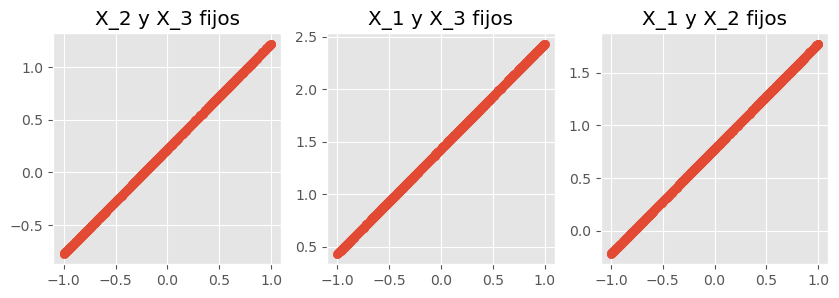

In [11]:
############## GENERACIÓN DE LOS DATOS
n_samples = 500
## Se genera el noise
noise_constant = 0.001
noise = np.random.normal(0,noise_constant,n_samples)

## Se generan los datos de la X
x_lim = [-1,1]
y_lim = [-1,1]
z_lim = [-1,1]
X_1 = np.linspace(x_lim[0],x_lim[1],n_samples)
X_2 = np.linspace(y_lim[0],y_lim[1],n_samples)
X_3 = np.linspace(z_lim[0],z_lim[1],n_samples)

def f_output(x1,x2,x3,noise):
    #return 0.5*x1**2 + 0.5*x2**2 + 0.5*x3**2 + noise
    #return np.exp(x1) + np.exp(x2) + np.exp(x3) + noise
    return x1 + x2 + x3 + noise
Y = f_output(X_1,X_2,X_3,noise)
print('La función es: Y = X_1^2 + X_2^2 + X_3^2 + noise')

### Vamos a comprobar como es monótona decreciente(creciente) al fijar los valores de X_2 y X_3 (X_1 y X_3, X_1 y X_2)

X_2_fijo = np.repeat(random.choice(X_2),n_samples)
X_3_fijo = np.repeat(random.choice(X_3),n_samples)
X_1_fijo = np.repeat(random.choice(X_1),n_samples)

Y_X2_X3_fijo = f_output(X_1,X_2_fijo,X_3_fijo,noise)
Y_X1_X3_fijo = f_output(X_1_fijo,X_2,X_3_fijo,noise)
Y_X1_X2_fijo = f_output(X_1_fijo,X_2_fijo,X_3,noise)

fig, axes = plt.subplots(1,3,figsize=(10,3))
axes[0].scatter(X_1,Y_X2_X3_fijo) 
axes[0].set_title("X_2 y X_3 fijos")
axes[1].scatter(X_2,Y_X1_X3_fijo)
axes[1].set_title("X_1 y X_3 fijos")
axes[2].scatter(X_3,Y_X1_X2_fijo)
axes[2].set_title("X_1 y X_2 fijos")

In [12]:
### DATA GENERATION
torch.manual_seed(2023)
np.random.seed(0)

# Crear una cuadrícula de valores que serviran como datos de train
n_samples = 20
x1_values = np.linspace(x_lim[0], x_lim[1], n_samples)
x2_values = np.linspace(y_lim[0], y_lim[1], n_samples)
x3_values = np.linspace(z_lim[0], z_lim[1], n_samples)
x1_mesh, x2_mesh, x3_mesh = np.meshgrid(x1_values, x2_values, x3_values)
## Juntamos y convertimos a tensor
mesh = np.hstack((x1_mesh.reshape(-1,1),x2_mesh.reshape(-1,1),x3_mesh.reshape(-1,1)))
noise_matr=np.random.multivariate_normal(mean=[0,0,0], cov=[[0, 0, 0], [0,0,0], [0,0,0]], size=len(mesh))
mesh = mesh+noise_matr
input_mesh = torch.tensor(mesh).float()
noise = np.random.normal(0,noise_constant,len(mesh))


## Convertimos los datos a un dataset para pytorch
y=torch.tensor(f_output(mesh[:,0],mesh[:,1],mesh[:,2],noise)).reshape(len(mesh),1).float()
print(len(y))

## Min max scaler to the output
y_min = torch.min(y)
y_max = torch.max(y)
def min_max_scaler(y,y_min=y_min,y_max=y_max):
    return (y-y_min)/(y_max-y_min)
y = min_max_scaler(y)

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(input_mesh, y, test_size=0.25, random_state=2023)

## Convertimos los datos a un dataset para pytorch
n_samples = len(X_train_tensor)
train_dt = TensorDataset(X_train_tensor,y_train_tensor) # create your datset
train_dataload = DataLoader(train_dt,batch_size=64) # create your dataloader

## Convertimos los datos a un dataset para pytorch
n_samples = len(X_test_tensor)
val_dt = TensorDataset(X_test_tensor,y_test_tensor) # create your datset
val_dataload = DataLoader(val_dt,batch_size=n_samples) # create your dataloader

8000


In [13]:
# Crear Scatter3d para datos de entrenamiento y prueba
scatter_train = go.Scatter3d(
    x=X_train_tensor[:, 0],
    y=X_train_tensor[:, 1],
    z=y_train_tensor[:, 0],
    mode='markers',
    marker=dict(size=4, opacity=0.7, color='blue'),
    name='Train Data'
)

scatter_test = go.Scatter3d(
    x=X_test_tensor[:, 0],
    y=X_test_tensor[:, 1],
    z=y_test_tensor[:, 0],
    mode='markers',
    marker=dict(size=4, opacity=0.7, color='red'),
    name='Test Data'
)

# Crear la superficie para la función subyacente

# Crear el gráfico
fig = go.Figure(data=[scatter_train, scatter_test])
fig.update_layout(scene=dict(zaxis_title='f(x1, x2)',aspectmode='cube'),
    width=1000,  # Cambia el ancho de la figura
    height=800)
fig.update_coloraxes(showscale=False)
fig.show()

In [14]:
## REPRESENTACIÓN -> Corte en el eje z
bound = torch.unique(X_train_tensor[:,2])[1].item()
X_train_tensor_bound = X_train_tensor[X_train_tensor[:,2]==bound,:2]
X_test_tensor_bound = X_test_tensor[X_test_tensor[:,2]==bound,:2]
y_train_tensor_bound = y_train_tensor[X_train_tensor[:,2]==bound,:2]
y_test_tensor_bound = y_test_tensor[X_test_tensor[:,2]==bound,:2]

# Crear Scatter3d para datos de entrenamiento y prueba
scatter_train = go.Scatter3d(
    x=X_train_tensor_bound[:, 0],
    y=X_train_tensor_bound[:, 1],
    z=y_train_tensor_bound[:, 0],
    mode='markers',
    marker=dict(size=4, opacity=0.7, color='blue'),
    name='Train Data'
)

scatter_test = go.Scatter3d(
    x=X_test_tensor_bound[:, 0],
    y=X_test_tensor_bound[:, 1],
    z=y_test_tensor_bound[:, 0],
    mode='markers',
    marker=dict(size=4, opacity=0.7, color='red'),
    name='Test Data'
)

# Crear la superficie para la función subyacente

# Crear el gráfico
fig = go.Figure(data=[scatter_train, scatter_test])
fig.update_layout(scene=dict(zaxis_title='f(x1, x2)',aspectmode='cube'),
    width=1000,  # Cambia el ancho de la figura
    height=800)
fig.update_coloraxes(showscale=False)
fig.show()

#### MODELLING

------------------ Entrenamiento MONOTONO EN X1, X2 Y X3 ------------------


[  0/200] Train Loss 0.045562, Train Loss Mod 0.045562, Val Loss 0.000089
[  1/200] Train Loss 0.000071, Train Loss Mod 0.000071, Val Loss 0.000053
[  2/200] Train Loss 0.000046, Train Loss Mod 0.000046, Val Loss 0.000035
[  3/200] Train Loss 0.000032, Train Loss Mod 0.000032, Val Loss 0.000025
[  4/200] Train Loss 0.000024, Train Loss Mod 0.000024, Val Loss 0.000019
[  5/200] Train Loss 0.000019, Train Loss Mod 0.000019, Val Loss 0.000015
[  6/200] Train Loss 0.000015, Train Loss Mod 0.000015, Val Loss 0.000013
[  7/200] Train Loss 0.000013, Train Loss Mod 0.000013, Val Loss 0.000011
[  8/200] Train Loss 0.000012, Train Loss Mod 0.000012, Val Loss 0.000010
[  9/200] Train Loss 0.000010, Train Loss Mod 0.000010, Val Loss 0.000009
[ 10/200] Train Loss 0.000009, Train Loss Mod 0.000009, Val Loss 0.000007
[ 11/200] Train Loss 0.000008, Train Loss Mod 0.000008, Val Loss 0.000006
[ 12/200] Train Loss 0.000007, Train Loss Mod 0.000007, Val Loss 0.000006
[ 13/200] Train Loss 0.000007, Train L

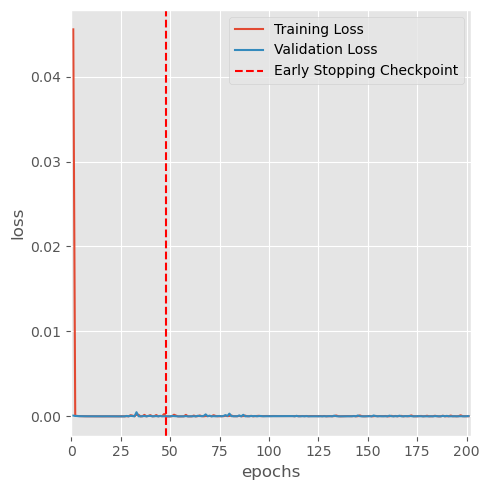

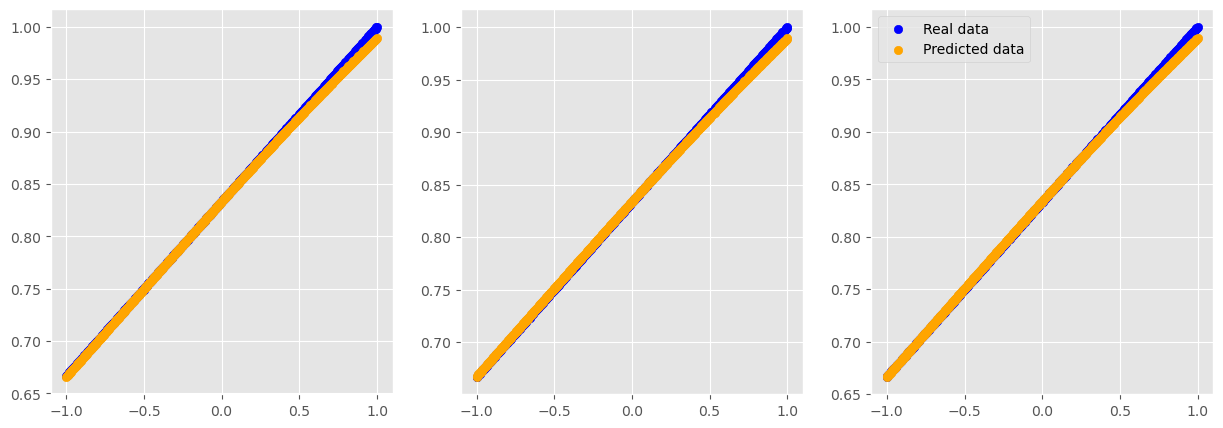

In [15]:
torch.manual_seed(0)

### MODEL DEFINITION ###
#model = MLP_Exponential(in_dim=in_dim,hidden_dim=hidden_dim, out_dim=out_dim)
layers = [3,20,1]
actfunc = ['sigmoid']
model = DNN(layers,activations=actfunc)
actfunc.insert(0,'identity')
actfunc.append('identity')

criterion = nn.MSELoss()
monotone_relations =[0,0,0]

mlp_model = MLP_Monotonic(_model_name="Prueba",_model = model)
print('------------------ Entrenamiento MONOTONO EN X1, X2 Y X3 ------------------')

mlp_model.train_adjusted_std(train_data=train_dataload,val_data=val_dataload,criterion=criterion,
                                 n_epochs=200,categorical_columns=[],verbose=1,n_visualized=1,
                                 monotone_relations=monotone_relations,optimizer_type='Adam',
                                 learning_rate=0.1,weight_decay=0.0e-4,delta=0.0,patience=500,
                                 delta_synthetic=0.0,delta_external=0.0,std_growth=0.0,epsilon_synthetic=0.0,
                                 model_path='./Models/checkpoint_mlp_',external_points=None,seed=2023)

print('------------------ Resultados Entrenamiento ------------------')
### Ploteado de resultados
mlp_model.plot_history()

## Generamos la matriz de datos de input con un valor fijado en x1, x2 o x3
fig,axes = plt.subplots(1,3,figsize=(15,5))
n_samples=500
valor_fijo_x2 = 1.0
valor_fijo_x3 = 1.0
matr_data = np.linspace((x_lim[0],valor_fijo_x2, valor_fijo_x3),(x_lim[1],valor_fijo_x2, valor_fijo_x3),n_samples)
matr = matr_data
input_matrix=torch.tensor(matr)
input_matrix=input_matrix.float()
noise = np.random.normal(0,noise_constant,n_samples)
output = f_output(input_matrix[:,0],valor_fijo_x2, valor_fijo_x3, noise)
## Min max scaled output 
output_normalized = min_max_scaler(output,y_min.numpy(),y_max.numpy())
axes[0].scatter(input_matrix[:,0],output_normalized, label='Real data',color='blue')
axes[0].scatter(input_matrix[:,0],model(input_matrix).detach().numpy(), label='Predicted data', color='orange')

valor_fijo_x1 = 1.0
matr_data = np.linspace((valor_fijo_x1,y_lim[0], valor_fijo_x3),(valor_fijo_x1,y_lim[1], valor_fijo_x3),n_samples)
matr = matr_data
input_matrix=torch.tensor(matr)
input_matrix=input_matrix.float()
noise = np.random.normal(0,noise_constant,n_samples)
output = f_output(valor_fijo_x1,input_matrix[:,1], valor_fijo_x3, noise)
## Min max scaled output 
output_normalized = min_max_scaler(output,y_min.numpy(),y_max.numpy())
axes[1].scatter(input_matrix[:,1],output_normalized, label='Real data',color='blue')
axes[1].scatter(input_matrix[:,1],model(input_matrix).detach().numpy(), label='Predicted data', color='orange')

valor_fijo_x1 = 1.0
valor_fijo_x2 = 1.0
matr_data = np.linspace((valor_fijo_x1,valor_fijo_x2, z_lim[0]),(valor_fijo_x1,valor_fijo_x2, z_lim[1]),n_samples)
matr = matr_data
input_matrix=torch.tensor(matr)
input_matrix=input_matrix.float()
noise = np.random.normal(0,noise_constant,n_samples)
output = f_output(valor_fijo_x1,valor_fijo_x2, input_matrix[:,2], noise)
## Min max scaled output 
output_normalized = min_max_scaler(output,y_min.numpy(),y_max.numpy())
axes[2].scatter(input_matrix[:,2],output_normalized, label='Real data',color='blue')
axes[2].scatter(input_matrix[:,2],model(input_matrix).detach().numpy(), label='Predicted data', color='orange')
plt.legend()

In [16]:
### EXTRACT INFORMATION FOR HESSIAN BOUNDING

## Take one input and output random (it does not matter since the objective is to bound the Hessian for all inputs)
x = train_dataload.dataset.tensors[0][0].view(1,-1)
y = train_dataload.dataset.tensors[1][0].view(1,-1)

weights, biases = utilities_voronoi.get_weights_and_biases(model)
############################################################################################################################################################################################################################
####################################################### ES NECESARIO MODIFICAR ESTO PARA CUANDO LA FEATURE MONÓTONA ES SOLO UNA!!!#######################################################
############################################################################################################################################################################################################################
W, Z, O, D, D2, D_accum, Q, H, counter, mlpstr = calculate_second_partial_derivatives_mlp(weights, biases,actfunc, x, y,sens_end_layer=len(actfunc))

## Calculate the Hessian for the first input
############################ REVISAR BIEN SI LA partial_monotonic_variable ES LA 1 O LA 2!!!
global_lipschitz_constant = utilities_voronoi.hessian_bound(W=W, actfunc=actfunc, partial_monotonic_variable=0, n_variables=3)
print('La constante de Lipschitz es: ', global_lipschitz_constant)


La constante de Lipschitz es:  1.403202039553164


In [17]:
## ANTES ERA 4.420738305911127

In [18]:
##### PLOT VORONOI WITH FURTHEST POINTS ##### -> Usando NeuralSens
importlib.reload(utilities_voronoi)

torch.manual_seed(0)
np.random.seed(0)
## Escogemos n puntos al azar de X_train_tensor
n_points = 10
selected_index = torch.randperm(len(X_train_tensor))[:n_points]
original_points = X_train_tensor[selected_index].numpy()
original_points_y = y_train_tensor[selected_index].numpy()
## Add to original points the point [1.0,0.5]
inputs = torch.tensor(original_points,dtype=torch.float)
outputs = []


## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
epsilon = 0.0001
intervals = [(x_lim[0], x_lim[1]), (y_lim[0], y_lim[1]), (z_lim[0], z_lim[1])]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
intervals_extended = [(x - epsilon, y + epsilon) for x, y in intervals]
vertices_extended = utilities_voronoi.generate_hypercube_vertices(intervals_extended)

## Compute original Voronoi diagram
original_vor = Voronoi(original_points,incremental=True)

## Compute symmetric points
all_points, _ = utilities_voronoi.add_symmetric_points(original_vor,vertices_extended,intervals_extended)

## Compute Voronoi diagram with symmetric points (and therefore bounded)
finite_vor = Voronoi(all_points,incremental=True)

## Compute the radios for each point
start_time = time.time()


radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius_neuralsens(inputs=inputs,outputs=outputs,weights=weights,biases=biases,
                                actfunc=actfunc,global_lipschitz_constant=global_lipschitz_constant,
                                monotone_relation=1,variable_index=[0,1,2],n_variables=3)
end_time = time.time()
print('Tiempo de ejecución: {}'.format(end_time-start_time))
## Load derivative sign
derivative_sign = [v[1] for k,v in dict_radios.items()]

## Plot Voronoi diagram
#utilities_voronoi.plot_finite_voronoi_2D(finite_vor,all_points,original_points,radius_tot,square_vertices,derivative_sign=derivative_sign,plot_symmetric_points=False)
utilities_voronoi.plot_finite_voronoi_3D(finite_vor,all_points,original_points,radius_tot,vertices,plot_symmetric_points=False)

## Check if the space is filled
#space_filled,distances = utilities_voronoi.check_space_filled(finite_vor,radius_tot,vertices)
space_filled, distances = utilities_voronoi.check_space_filled_vectorized(finite_vor,dict_radios,vertices)
print('El espacio está relleno: {}'.format(space_filled))

Tiempo de ejecución: 0.010039329528808594


El espacio está relleno: False


In [10]:
##### PLOT VORONOI WITH FURTHEST POINTS ##### -> Usando NeuralSens
importlib.reload(utilities_voronoi)

torch.manual_seed(0)
np.random.seed(0)
## Escogemos n puntos al azar de X_train_tensor
n_points = 100
selected_index = torch.randperm(len(X_train_tensor))[:n_points]
original_points = X_train_tensor[selected_index].numpy()
original_points_y = y_train_tensor[selected_index].numpy()
## Add to original points the point [1.0,0.5]
inputs = torch.tensor(original_points,dtype=torch.float)
outputs = []


## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
epsilon = 0.0001
intervals = [(x_lim[0], x_lim[1]), (y_lim[0], y_lim[1]), (z_lim[0], z_lim[1])]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
intervals_extended = [(x - epsilon, y + epsilon) for x, y in intervals]
vertices_extended = utilities_voronoi.generate_hypercube_vertices(intervals_extended)

## Compute original Voronoi diagram
original_vor = Voronoi(original_points,incremental=True)

## Compute symmetric points
all_points, _ = utilities_voronoi.add_symmetric_points(original_vor,vertices_extended,intervals_extended)

## Compute Voronoi diagram with symmetric points (and therefore bounded)
finite_vor = Voronoi(all_points,incremental=True)

## Compute the radios for each point
start_time = time.time()


radius_tot,dict_radios,x_reentrenamiento = utilities_voronoi.get_lipschitz_radius_neuralsens(inputs=inputs,outputs=outputs,weights=weights,biases=biases,
                                actfunc=actfunc,global_lipschitz_constant=global_lipschitz_constant,
                                monotone_relation=1,variable_index=[0,1,2],n_variables=3)
end_time = time.time()
print('Tiempo de ejecución: {}'.format(end_time-start_time))
## Load derivative sign
derivative_sign = [v[1] for k,v in dict_radios.items()]

## Check if the space is filled
#space_filled,distances = utilities_voronoi.check_space_filled(finite_vor,radius_tot,vertices)
space_filled, distances = utilities_voronoi.check_space_filled_vectorized(finite_vor,dict_radios,vertices)
print('El espacio está relleno: {}'.format(space_filled))

Tiempo de ejecución: 0.03470444679260254
El espacio está relleno: False


In [25]:
## Add points to the Voronoi diagram
importlib.reload(utilities_voronoi)
#utilities_voronoi.add_points_to_voronoi(original_vor,original_points,finite_vor,dict_radios,vertices,distances,model,global_lipschitz_constant,x_lim,y_lim,monotone_relations=1,variable_index=[0,1],n_variables=2,plot_voronoi=False,epsilon=1e-5,max_iterations=10000)
utilities_voronoi.add_points_to_voronoi(original_vor=original_vor,original_points=original_points,finite_vor=finite_vor,dict_radios=dict_radios,
                                        vertices=vertices,distances=distances,model=model,global_lipschitz_constant=global_lipschitz_constant,
                                        actfunc=config['model_architecture']['actfunc'],intervals=intervals,monotone_relations=1,variable_index=[0,1,2],
                                        n_variables=3,plot_voronoi=False,epsilon=1e-5,max_iterations=5000)

Using NeuralSens
The space is filled: True after 58 iterations 


## GENERACIÓN DE INTERVALOS

### 1 DIMENSION

In [ ]:
## Definimos las funciones cuadrática y su derivada
def squared_function(x):
    return x ** 2

def derivative_squared_function(x):
    return 2 * x


In [ ]:
##### EJEMPLO

##### NO RELLENA EL INTERVALO
conjunto_intervalos = [[1, 2],[1,2.75], [3, 4]]
intervalo_deseado = [1, 4]

utilities_voronoi.plot_intervalos(conjunto_intervalos, intervalo_deseado)


if utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado):
    print("El conjunto de intervalos rellena completamente el intervalo deseado.")
else:
    print("El conjunto de intervalos NO rellena completamente el intervalo deseado.")

#### RELLENA EL INTERVALO

conjunto_intervalos = [[1, 2],[1,3.75], [3, 4]]
intervalo_deseado = [1, 4]

utilities_voronoi.plot_intervalos(conjunto_intervalos, intervalo_deseado)


if utilities_voronoi.verifica_relleno(conjunto_intervalos, intervalo_deseado):
    print("El conjunto de intervalos rellena completamente el intervalo deseado.")
else:
    print("El conjunto de intervalos NO rellena completamente el intervalo deseado.")

### 2 DIMENSIONES

In [ ]:
# Definimos la función cuadrática de dos variables y su derivada parcial
def squared_function(x, y):
    return x ** 2 + y ** 2

def derivative_squared_function_x(x, y):
    return 2 * x

def derivative_squared_function_y(x, y):
    return 2 * y
np.random.seed(0)
# Tomamos al azar una serie de puntos en 2D dentro de un rango
points = np.random.uniform(1, 5, size=(5, 2))
print("Puntos en 2D:")
print(points)

# Calculamos la constante de Lipschitz
lipschitz_constant = 2 * np.sqrt(5)  # Usamos la norma L2 de los puntos [1, 5]

# Crear figuras para la representación gráfica
fig, ax = plt.subplots()

# Construimos los intervalos alrededor de la bola y representamos los puntos
for i, (x, y) in enumerate(points):
    h_x = derivative_squared_function_x(x, y) / lipschitz_constant
    h_y = derivative_squared_function_y(x, y) / lipschitz_constant
    radius = min(h_x, h_y)
    print("Radio del círculo alrededor del punto {}: {}".format(i + 1, radius))
    
    # Dibuja el círculo correspondiente al intervalo
    circle = Circle((x, y), radius, fill=True, color='red', alpha=0.25, linestyle='--')
    ax.add_patch(circle)

# Representa los puntos en el plano
plt.scatter(points[:, 0], points[:, 1], c='red', label='Puntos')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Puntos en 2D con círculos de intervalo')
plt.grid(True)

# Muestra el gráfico
plt.show()



In [ ]:
# Definimos la función cuadrática de dos variables y su derivada parcial

def squared_function(x, y):
    return x ** 2 + y ** 2

def derivative_squared_function_x(x, y):
    return 2 * x

def derivative_squared_function_y(x, y):
    return 2 * y

# Tomamos al azar una serie de puntos en 2D dentro de un rango
points = np.random.uniform(0.5, 3, size=(5, 2))
print("Puntos en 2D:")
print(points)

# Calculamos la constante de Lipschitz
lipschitz_constant = 2 * np.sqrt(5)  # Usamos la norma L2 de los puntos [1, 5]

radius_tot = []
# Construimos los intervalos alrededor de la bola y representamos los puntos
for i, (x, y) in enumerate(points):
    h_x = derivative_squared_function_x(x, y) / lipschitz_constant
    h_y = derivative_squared_function_y(x, y) / lipschitz_constant
    radius = min(h_x, h_y)
    radius_tot.append(radius)
    print("Radio del círculo alrededor del punto {}: {}".format(i + 1, radius))


vor = Voronoi(points, furthest_site=False,incremental=True)

#radius_tot = np.random.uniform(0.1, 0.7,len(vor.points))
dists, max_distances, radius_tot = utilities.generate_voronoi_diagram(vor,radius_tot,verbose=False)

## Extra

### 2DIMENSION

In [ ]:
### AÑADIENDO UN NUEVO PUNTO AL VORONOI DIAGRAM
np.random.seed(seed=0)

points = np.array([[0, 0.1], [0, 1.5], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])

vor = Voronoi(points, furthest_site=False,incremental=True)

radius_tot = np.random.uniform(0.1, 0.7,len(vor.points))
dists, max_distances, radius_tot = utilities.generate_voronoi_diagram(vor,radius_tot,verbose=False)

In [ ]:
np.random.seed(seed=0)

for i in range(5):
    ### AÑADIENDO UN NUEVO PUNTO AL VORONOI DIAGRAM

    new_point = utilities.add_new_point(vor, dists,radius_tot, vor.points)

    vor.add_points([new_point])
    radius_tot = np.random.uniform(0.1, 0.7,len(vor.points))

    dists, max_distances, radius_tot =  utilities.generate_voronoi_diagram(vor,radius_tot)

In [ ]:
# Configuración de generación de GIF
save_gif = True  # Establece esto en True para guardar el GIF
gif_filename = 'voronoi_animation.gif'
frames =10  # Número de cuadros en el GIF
np.random.seed(seed=0)


points = np.array([[0, 0.1], [0, 1.5], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])

vor = Voronoi(points, furthest_site=False,incremental=True)


if save_gif:
    fig, axes = plt.subplots(figsize=(6, 6))

for frame in range(frames):

    new_point = utilities.add_new_point(vor, dists,radius_tot, vor.points)
    vor.add_points([new_point])
    radius_tot = np.random.uniform(0.1, 0.7,len(vor.points))
    dists, max_distances, radius_tot =  utilities.generate_voronoi_diagram(vor,radius_tot,save_gif=True,frame=frame)
    
    if save_gif:
        axes.cla()  # Borrar el gráfico anterior
        voronoi_plot_2d(vor, ax=axes)



if save_gif:
    import os
    import imageio

    images = [f'frame_{i}.png' for i in range(frames)]
    with imageio.get_writer(gif_filename, mode='I') as writer:
        for image in images:
            writer.append_data(imageio.imread(image))
    for image in images:
        os.remove(image)

if save_gif:
    plt.close()
else:
    plt.show()

#### UNDERSTANDING VORONOI CODE

In [ ]:
#### CODIGO A ENTENDER
from collections import defaultdict

from shapely.geometry import Polygon
# Mapping from (input point index, Voronoi point index) to list of
# unit vectors in the directions of the infinite ridges starting
# at the Voronoi point and neighbouring the input point.

centroid = vor.points.mean(axis=0)

ridge_direction = defaultdict(list)
for (p, q), rv in zip(vor.ridge_points, vor.ridge_vertices):
    u, v = sorted(rv)
    if u == -1:
        # Infinite ridge starting at ridge point with index v,
        # equidistant from input points with indexes p and q.
        t = vor.points[q] - vor.points[p] # tangent
        n = np.array([-t[1], t[0]]) / np.linalg.norm(t) # normal
        midpoint = vor.points[[p, q]].mean(axis=0)
        direction = np.sign(np.dot(midpoint - centroid, n)) * n
        ridge_direction[p, v].append(direction)
        ridge_direction[q, v].append(direction)
    """si el producto escalar es positivo, significa que la dirección debe ser igual a n, y si es negativo, la dirección debe ser igual a -n.
La razón para calcular la dirección de esta manera es asegurar que el borde infinito se extienda desde el centroide general del conjunto de 
puntos hacia el punto medio del borde, siguiendo la dirección de la normal n. Esto garantiza que las regiones infinitas se extiendan de manera 
coherente y orientada adecuadamente desde los vértices de Voronoi.
    """

for i, r in enumerate(vor.point_region):
    region = vor.regions[r]
    if -1 not in region:
        # Finite region.
        yield Polygon(vor.vertices[region]) ## En caso de que sea finita se salta el siguiente paso y se devuelve el polígono
        continue
    # Infinite region.
    inf = region.index(-1)              # Index of vertex at infinity.
    j = region[(inf - 1) % len(region)] # Index of previous vertex.
    k = region[(inf + 1) % len(region)] # Index of next vertex.
    if j == k:
        # Region has one Voronoi vertex with two ridges.
        dir_j, dir_k = ridge_direction[i, j]
    else:
        # Region has two Voronoi vertices, each with one ridge.
        dir_j, = ridge_direction[i, j]
        dir_k, = ridge_direction[i, k]

    # Length of ridges needed for the extra edge to lie at least
    # 'diameter' away from all Voronoi vertices.
    length = 2 * diameter / np.linalg.norm(dir_j + dir_k)

    # Polygon consists of finite part plus an extra edge.
    finite_part = vor.vertices[region[inf + 1:] + region[:inf]]
    extra_edge = [vor.vertices[j] + dir_j * length,
                    vor.vertices[k] + dir_k * length]
    yield Polygon(np.concatenate((finite_part, extra_edge)))

In [ ]:
centroid = vor.points.mean(axis=0)
print(centroid)

In [ ]:
p=0
q=3
t = vor.points[3] - vor.points[0] # tangent
n = np.array([-t[1], t[0]]) / np.linalg.norm(t) # normal
midpoint = vor.points[[p, q]].mean(axis=0)
direction = np.sign(np.dot(midpoint - centroid, n)) * n
print(direction)

### 3DIMENSION

In [37]:
## Selecciono los puntos que definen el tetraedro unitario en 3D
import numpy as np

# Definir los puntos en 2D
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])

# Alturas que queremos añadir a los puntos
alturas = [0, 0.5, 1]

# Crear una lista para almacenar los puntos en 3D
points_3d = []

# Iterar sobre los puntos y alturas para crear los puntos en 3D
for altura in alturas:
    for punto in points:
        punto_3d = np.append(punto, altura)
        points_3d.append(punto_3d)

# Convertir la lista de puntos en 3D a un array de NumPy
points_3d = np.array(points_3d)

# Imprimir los puntos en 3D resultantes
points_3d


array([[0. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 2. , 0. ],
       [1. , 0. , 0. ],
       [1. , 1. , 0. ],
       [1. , 2. , 0. ],
       [2. , 0. , 0. ],
       [2. , 1. , 0. ],
       [2. , 2. , 0. ],
       [0. , 0. , 0.5],
       [0. , 1. , 0.5],
       [0. , 2. , 0.5],
       [1. , 0. , 0.5],
       [1. , 1. , 0.5],
       [1. , 2. , 0.5],
       [2. , 0. , 0.5],
       [2. , 1. , 0.5],
       [2. , 2. , 0.5],
       [0. , 0. , 1. ],
       [0. , 1. , 1. ],
       [0. , 2. , 1. ],
       [1. , 0. , 1. ],
       [1. , 1. , 1. ],
       [1. , 2. , 1. ],
       [2. , 0. , 1. ],
       [2. , 1. , 1. ],
       [2. , 2. , 1. ]])

IndexError: index 2 is out of bounds for axis 1 with size 2

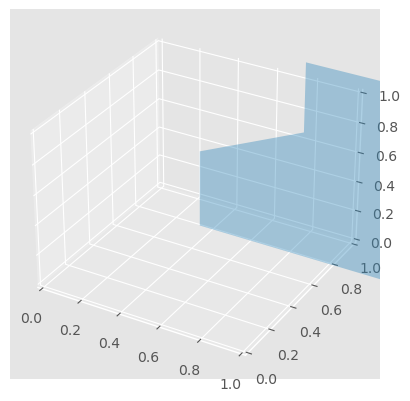

In [38]:
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Generate random points in 3D space
np.random.seed(0)

# Create a Voronoi diagram
vor = Voronoi(points_3d)

# Plot the Voronoi cells in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Iterate through Voronoi vertices and regions
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        polygon = [vor.vertices[i] for i in region]
        poly = Poly3DCollection([polygon], alpha=0.4)
        ax.add_collection3d(poly)

# Plot the original points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='red', marker='o')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()


In [39]:
import numpy as np
from scipy.spatial import Voronoi
import plotly.graph_objs as go

# Generate random points in 3D space
np.random.seed(0)
points = np.array([[1,0,0],[0,1,0],[0,0,1],[0,0,0],[1,0,1],[0,1,1],[0.5,0,0],[0,0.5,0],[0,0,0.5],[0.5,0,0.5],[0,0.5,0.5],[0.5,0.5,0]])
# Create a Voronoi diagram
#vor = Voronoi(points)
vor = Voronoi(points_3d)

# Create a list of 3D scatter points for the Voronoi vertices
voronoi_vertices = go.Scatter3d(
    x=vor.vertices[:, 0],
    y=vor.vertices[:, 1],
    z=vor.vertices[:, 2],
    mode='markers',
    marker=dict(size=5, color='red')
)

# Create a list of 3D scatter points for the original points
original_points = go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(size=8, color='blue')
)

# Create a list of 3D scatter points for the Voronoi ridge points
ridge_points = []
for ridge in vor.ridge_vertices:
    if -1 not in ridge:
        ridge_points.append(go.Scatter3d(
            x=[vor.vertices[ridge[0], 0], vor.vertices[ridge[1], 0]],
            y=[vor.vertices[ridge[0], 1], vor.vertices[ridge[1], 1]],
            z=[vor.vertices[ridge[0], 2], vor.vertices[ridge[1], 2]],
            mode='lines',
            line=dict(color='green')
        ))

# Create the layout for the 3D plot
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    )
)

# Create a Plotly figure
fig = go.Figure(data=[voronoi_vertices, original_points] + ridge_points, layout=layout)

# Show the interactive 3D plot
fig.show()


In [ ]:
import numpy as np
from scipy.spatial import Voronoi
import plotly.graph_objs as go

# Genera puntos aleatorios en el espacio 3D
np.random.seed(0)
points = np.array([[1,0,0],[0,1,0],[0,0,1],[0,0,0],[1,0,1],[0,1,1],[0.5,0,0],[0,0.5,0],[0,0,0.5],[0.5,0,0.5],[0,0.5,0.5],[0.5,0.5,0]])
points = np.array([[0, 0,0], [0, 1,0], [0, 2,0], [1, 0,0], [1, 1,0], [1, 2,0],
                   [2, 0,0], [2, 1,0], [2, 2,1]])
# Crea un diagrama de Voronoi
vor = Voronoi(points)

# Crea una lista de puntos 3D para los vértices de Voronoi
voronoi_vertices = go.Scatter3d(
    x=vor.vertices[:, 0],
    y=vor.vertices[:, 1],
    z=vor.vertices[:, 2],
    mode='markers',
    marker=dict(size=5, color='red')
)

# Crea una lista de puntos 3D para los puntos originales
original_points = go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(size=8, color='blue')
)

# Crea una lista de puntos 3D para los puntos de los bordes de Voronoi (hiperplanos)
ridge_points = []
for ridge in vor.ridge_vertices:
    if -1 not in ridge:
        ridge_points.append(go.Scatter3d(
            x=[vor.vertices[ridge[0], 0], vor.vertices[ridge[1], 0]],
            y=[vor.vertices[ridge[0], 1], vor.vertices[ridge[1], 1]],
            z=[vor.vertices[ridge[0], 2], vor.vertices[ridge[1], 2]],
            mode='lines',
            line=dict(color='green', width=2)
        ))

# Crea el trazado para representar los hiperplanos
ridge_lines = []
for ridge in vor.ridge_points:
    if -1 not in ridge:
        ridge_lines.append(go.Scatter3d(
            x=[vor.points[ridge[0], 0], vor.points[ridge[1], 0]],
            y=[vor.points[ridge[0], 1], vor.points[ridge[1], 1]],
            z=[vor.points[ridge[0], 2], vor.points[ridge[1], 2]],
            mode='lines',
            line=dict(color='purple', width=3)
        ))

# Crea el diseño para el gráfico 3D
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    )
)

# Crea la figura de Plotly
fig = go.Figure(data=[voronoi_vertices, original_points] + ridge_points + ridge_lines, layout=layout)

# Muestra el gráfico 3D interactivo
fig.show()
